In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import math
import time
import matplotlib.gridspec as gridspec

from astropy.io import ascii
from itertools import cycle
from itertools import permutations
from scipy.stats import skew, mode

%matplotlib inline

# Plotting code

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """

    nColours = np.max(mappableList)+1
    uniqueMappableList = np.arange(nColours)
    
    zidx = np.array((mappableList))

    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= nColours: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,nColours):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [3]:
def makePlot(ax, xdata, ydata, colours, xlabel, ylabel, 
             linkSystems=False, sysIdxs=None,
             sizes=30, legendTitle=None,legendEntries=None, legendColours=None,
             xlim=[], ylim=[],xscale="linear",yscale="linear",alpha=1):
    ax.scatter(xdata,ydata,c=colours,s=sizes,alpha=alpha)
    #ax.hexbin(xdata,ydata,cmap='Blues')
    nonans = (np.isfinite(xdata) & np.isfinite(ydata))
    xdata=xdata[nonans]
    ydata=ydata[nonans]
    colours=colours[nonans]
    
    xmin = np.min(xdata)#.value
    xmax = np.max(xdata)#.value
    
    ymin = np.min(ydata)#.value
    ymax = np.max(ydata)#.value

    if not xlim:
        if xscale=="log":
            ax.set_xlim(0.1*xmin,10.*xmax)
        else:
            ax.set_xlim(0.95*xmin,1.05*xmax)
    else:
        ax.set_xlim(xlim)
        
    if not ylim:
        if yscale=="log":
            ax.set_ylim(0.1*ymin,10.*ymax)
        else:
            ax.set_ylim(0.95*ymin,1.05*ymax)
    else:
        ax.set_ylim(ylim)
    
    ax.set_xscale(xscale)
    ax.set_yscale(yscale)
    
    #ax.set_xlabel(xlabel,fontsize=24)
    #ax.set_ylabel(ylabel,fontsize=24)
    ax.tick_params(labelsize=18)
    
    if legendEntries is not None:
        if xscale=="log":
            minx = 1.e-7*xmin
        else:
            minx = -1000+(-1000*xmin)
                
        if yscale=="log":
            miny = 1.e-7*ymin
        else:
            miny = -1000+(-1000*ymin)
            
        for i in range(0,len(legendEntries)):
            ax.scatter([minx,minx],[miny,miny],s=200,c=legendColours[i],edgecolors=legendColours[i],label='{0}'.format(legendEntries[i]))
        leg=ax.legend(loc=0,ncol=1,frameon=False,fontsize=15,title=legendTitle)
        leg.get_title().set_fontsize('22')
        
    if linkSystems is True:
        for i in np.unique(sysIdxs):
            if len(xdata[sysIdxs==i]) > 1:
                if "P" in xlabel:
                    psort = np.argsort(xdata[sysIdxs == i])
                    ax.plot(xdata[sysIdxs==i][psort],ydata[sysIdxs==i][psort],lw=0.5,marker='None',ls='-',color='k',alpha=alpha)
                elif "P" in ylabel:
                    psort = np.argsort(ydata[sysIdxs == i])
                    ax.plot(xdata[sysIdxs==i][psort],ydata[sysIdxs==i][psort],lw=0.5,marker='None',ls='-',color='k',alpha=alpha)
                else:
                    sort = np.argsort(xdata[sysIdxs == i])
                    ax.plot(xdata[sysIdxs==i][sort],ydata[sysIdxs==i][sort],lw=0.5,marker='None',ls='-',color='k',alpha=alpha)
                
            #else:
            #    ax.plot(xdata[sysIdxs==i],ydata[sysIdxs==i],lw=0.5,marker='o',ms=np.sqrt(sizes),mec='k',mfc='None',ls='None',color='k',alpha=alpha)
            
    # for period-radius plane plot
    #ylabelplot = ax.twinx()
    #ylabelplot.grid(False)
    #ylabelplot.set_ylim(ylim)
    #ylabelplot.set_yticks(np.log10(np.array((1.0,1.8,3.86,11.2))))
    #ylabelplot.set_yticklabels([r'$R_{\mathrm{Earth}}$','approx. middle of\nphotoevaporation\nvalley',r'$R_{\mathrm{Neptune}}$',r'$R_{\mathrm{Jupiter}}$'])
    return 

In [4]:
def getLossFromLogfile(filename):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    lastEpoch = content[-5].split("|")
    try:
        lastEpochCost = float(lastEpoch[2].split(" ")[2])
    #catch nans
    except ValueError:
        lastEpochCost = 0.
    return lastEpochCost

# Loop over different choices of num_classes

In [5]:
KOIs = ascii.read("../KOIs_chen2018_goodSystems_incJupiters.csv")

obs_features = np.vstack((np.log10(np.array(KOIs['koi_ror'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T
mod_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_sma'])).T,np.log10(np.array(KOIs['koi_insol'])).T,np.log10(np.array(KOIs['koi_srad'])).T,np.log10(np.array(KOIs['koi_smass'])).T)).T
final_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T



In [6]:
print(np.max(np.array(KOIs['koi_period'])))

1693.6636225


In [7]:
# stuff that's true regardless of num_classes
trainingDataFile = "./realPlanets_incJ_final/realKOIs_finalFeatures_incJ_70percent.txt"
CVDataFile = "./realPlanets_incJ_final/realKOIs_finalFeatures_incJ_30percent.txt"

# constraints based on stability
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
#constraints = np.genfromtxt("./realPlanets_obs/realKOIs_targetConstraints.txt")

n_planet_features = 2
n_stellar_features = 2
n_features = n_planet_features + n_stellar_features

# for predictions
n_samples = 100


features = final_features
mus = np.mean(features,axis=0)
sigmas = np.std(features,axis=0)


# obs
#labels = [r'$\log_{10}R_p/R_*$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
#lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
#scatterlims = [(-2.5,-1.),(-0.75,3.25),(4000,7000),(3.75,5.25)]

# mod
#labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}a$ [AU]',r'$\log_{10}S\ [S_\oplus]$',r'$\log_{10}R_*\ [R_\odot]$',r'$\log_{10}M_*\ [M_\odot]$']
#lims = [(-2,2),(-2,2),(-1.,1.),(-1.,1.),(-1.,1.)]
#scatterlims = [(-0.5,1.25),(-0.75,3),(-3,3),(-3,3),(-3,3)]

# final
labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
scatterlims = [(-0.5,1.5),(-0.75,3.25),(4000,7000),(3.75,5.25)]


classColoursList = ['#36747d','#f6aa1c','#7a1809','#003049','#2e4d9f',
                    '#bf3e0b','#064f40','#432371','#007f5f','#613dc1']

#classColoursList = ['#f6aa1c','#7a1809','#2e4d9f','#bf3e0b','#007f5f',
#                    '#613dc1','#003049','#36747d','#064f40','#432371']

singleColourList = ['#000000']

# Figure out which random seed 0,...,99 and which n_classes 2,...,15 had the optimal cost function.

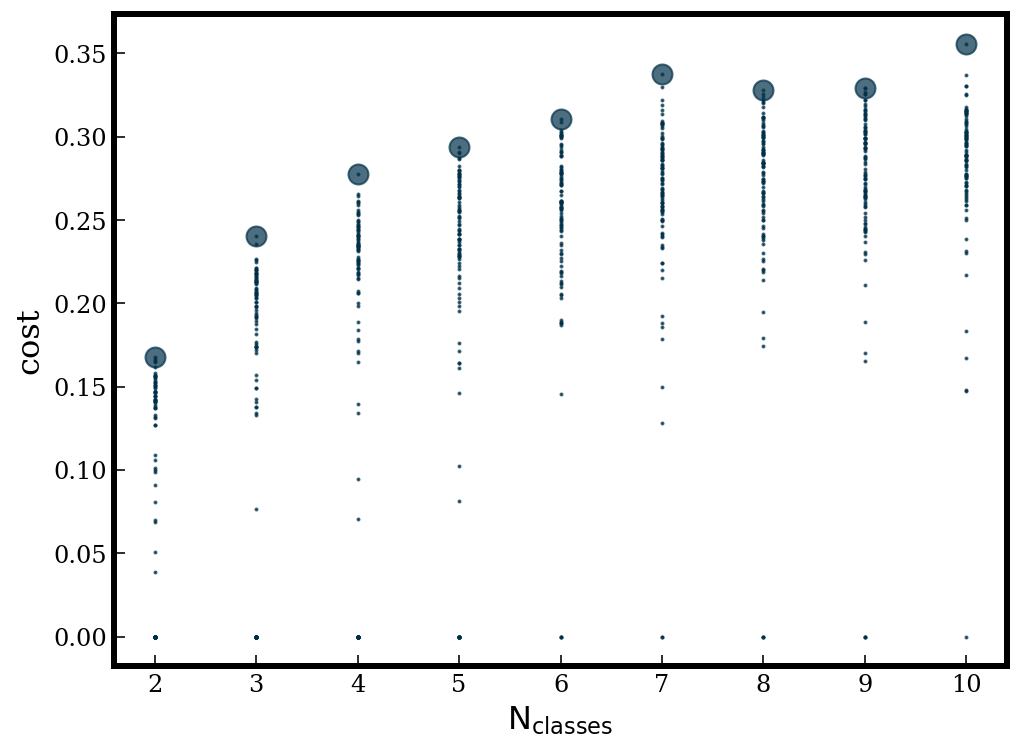

In [8]:
loss_arr = np.zeros((9,100))

for i, nc in enumerate(range(2,11)):
    for j, s in enumerate(range(0,100)):
        resultsFolder = "./realPlanets_incJ_final/{0}classes".format(nc)
        loss_arr[i,j] = getLossFromLogfile("{0}/realKOIs_finalFeatures_incJ_{1}classes_seed={2}.log".format(resultsFolder,nc,s))


fig = plt.figure(figsize=(8,6))
for j in range(100):
    plt.plot(np.arange(2,11),-1*loss_arr[:,j],color='#003049',marker='.',ls="None",ms=2,alpha=0.7)
#plt.plot(np.arange(2,11),-1*np.median(loss_arr,axis=1),color='#003049',marker='.',ls="None",ms=20,alpha=0.7)
plt.plot(np.arange(2,11),-1*np.min(loss_arr,axis=1),color='#003049',marker='.',ls="None",ms=20,alpha=0.7)
#plt.plot(np.arange(2,11),-1*np.min(loss_arr,axis=1),mec='k',mfc='None',marker='.',ls="None",ms=15,alpha=0.7)
plt.xlabel(r"$\mathrm{N}_{\mathrm{classes}}$",fontsize=16)
plt.ylabel("cost",fontsize=16)

plt.savefig("./realPlanets_incJ_final/cost_vs_nclasses_maximizeJ_incJ.pdf",fmt="pdf",bbox_inches="tight")


In [9]:
print(np.min(loss_arr,axis=1))
print(np.argmin(loss_arr,axis=1))

[-0.16773761 -0.24059744 -0.27742195 -0.29402522 -0.31077193 -0.33780142
 -0.32775814 -0.32945434 -0.35589796]
[87 87  4 89 80  3 29 80 29]


# training data

In [21]:
# classification plots for training data first
classes = np.arange(2,11)
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)

for n_idx in np.arange(len(classes)):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

    # get training data
    with open(trainingDataFile, "rb") as picklefile:
        trainingSystems = pickle.load(picklefile)

    data = np.zeros((1,n_features+1))

    for i in range(len(trainingSystems)):
        sys = trainingSystems[i]
        for j in range(1,len(sys)):
            row = np.zeros_like(data[0])
            row[:-1] = np.array(sys[j])
            row[-1] = i
            data = np.vstack((data,row))
    data = data[1:]
    #print(data)
    #print(np.shape(data))

    mults = np.zeros_like(data[:,0])
    for i in range(len(data)):
        thisSystemMask = (data[:,-1] == data[i,-1])
        mults[i] = int(len(data[thisSystemMask]))
    
    data = np.hstack((data,np.atleast_2d(mults).T))
    
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
    results = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    results_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_70percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    idxs = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_idxs_{1}.npy".format(resultsFolder,seed))

    data = data[idxs]

    bestClass = np.argmax(results,axis=1)
    bestClass_fromContext = np.argmax(results_fromContext,axis=1)
    
    # TRUTHS and RESULTS
    arrays_ = [bestClass,bestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in np.sort(np.unique(mults)):
        print("mult is {0}".format(m))
        data_toplot = data[data[:,-1] == m]
        #print(np.shape(data_toplot))
        arrays_ = [bestClass[data[:,-1]==m],bestClass_fromContext[data[:,-1]==m]]
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

            fig = plt.figure(figsize=(7*n_features,7*n_features))
            gs = gridspec.GridSpec(n_features, n_features)

            for i in range(n_features):
                for j in range(n_features):
                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        makePlot(ax,
                                xdata=((data_toplot[:,j]*sigmas[j])+mus[j]),#+arrays_[h]/3.,
                                ydata=((data_toplot[:,i]*sigmas[i])+mus[i]),
                                linkSystems=True,
                                sysIdxs=data_toplot[:,-2].astype(int),
                                colours=class_colours,
                                xlim=scatterlims[j],#scaledLimits[j],
                                ylim=scatterlims[i],#scaledLimits[i],
                                #legendTitle="{0}\nclass\nindex".format(titles_[h]),
                                #legendEntries=np.array(class_legendEntries).astype(int),
                                #legendColours=class_legendColours,
                                #xscale="log",
                                #yscale="log",
                                xlabel=labels[j],
                                ylabel=labels[i],
                                alpha=0.25)

                    if i==j:
                        ax = plt.subplot(gs[i,j])
                        toHist = []
                        nmax = 0
                        for k in np.unique(arrays_[h]).astype(int):
                            #toHist.append(data[:,i][arrays_[h]==k])
                            try:
                                #n,bins,patches=ax.hist(data[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((data_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==k],bins=100,color=class_legendColours[k],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)
                            except IndexError:
                                #n,bins,patches=ax.hist(data[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((data_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)

                        #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                        #nmax = np.max(n)
                        ax.set_xlabel(labels[i],fontsize=24)
                        ax.tick_params(labelsize=18)
                        ax.set_xlim(scatterlims[i])
                        ax.set_ylim(0,nmax*1.1)


            plt.subplots_adjust(wspace=0.2,hspace=0.2)
            #plt.show()

            plt.savefig("{0}/realKOIs_finalFeatures_incJ_70percent_{1}classes_{2}_{3}_mult={4}.png".format(resultsFolder,n_classes,plotTitles_[h],seed,m),fmt="png")
            plt.close()

n_classes is 2
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
mult is 7.0
n_classes is 3
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
mult is 7.0
n_classes is 4
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
mult is 7.0
n_classes is 5
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
mult is 7.0
n_classes is 6
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
mult is 7.0
n_classes is 7
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
mult is 7.0
n_classes is 8
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
mult is 7.0
n_classes is 9
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
mult is 7.0
n_classes is 10
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
mult is 7.0


# CV data, split by multiplicity

In [22]:
classes = np.arange(2,11)
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)
print(seeds)

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

    CVdata = np.zeros((1,n_features+1))
    #CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        # organize constraints in the same order
        '''
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
        '''
    CVdata = CVdata[1:]
    #CVconstraints = CVconstraints[1:]
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    #CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)
    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in np.sort(np.unique(mults)):
        print("mult is {0}".format(m))
        CVdata_toplot = CVdata[CVdata[:,-1] == m]
        arrays_ = [CVbestClass[CVdata[:,-1]==m],CVbestClass_fromContext[CVdata[:,-1]==m]]
        
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

            fig = plt.figure(figsize=(7*n_planet_features,7*(n_planet_features)))
            gs = gridspec.GridSpec((n_planet_features), (n_planet_features))

            for i in range(n_planet_features):
                for j in range(n_planet_features):
                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        makePlot(ax,
                                xdata=((CVdata_toplot[:,j]*sigmas[j])+mus[j]),#+arrays_[h]/3.,
                                ydata=((CVdata_toplot[:,i]*sigmas[i])+mus[i]),
                                linkSystems=True,
                                sysIdxs=CVdata_toplot[:,-2].astype(int),
                                colours=class_colours,
                                xlim=scatterlims[j],#scaledLimits[j],
                                ylim=scatterlims[i],#scaledLimits[i],
                                #legendTitle="{0}\nclass\nindex".format(titles_[h]),
                                #legendEntries=np.array(class_legendEntries).astype(int),
                                #legendColours=class_legendColours,
                                #xscale="log",
                                #yscale="log",
                                xlabel=labels[j],
                                ylabel=labels[i],
                                alpha=1)
                    '''
                    if i==j:
                        ax = plt.subplot(gs[i,j])
                        toHist = []
                        nmax = 0
                        for k in np.unique(arrays_[h]).astype(int):
                            #toHist.append(CVdata[:,i][arrays_[h]==k])
                            try:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==k],bins=100,color=class_legendColours[k],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)
                            except IndexError:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas[i])+mus[i])[arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scatterlims[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)

                        #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                        #nmax = np.max(n)
                        ax.set_xlabel(labels[i],fontsize=24)
                        ax.tick_params(labelsize=18)
                        ax.set_xlim(scatterlims[i])
                        ax.set_ylim(0,nmax*1.1)

                        '''
            plt.subplots_adjust(wspace=0.2,hspace=0.2)
            #plt.show()

            plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_mult={4}_planetFeaturesOnly_noHist.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed,m),fmt="pdf",bbox_inches="tight")
            #plt.savefig("{0}/realKOIs_finalFeatures_{1}classes_{2}_{3}_mult={4}_planetFeaturesOnly.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed,m),fmt="pdf",bbox_inches="tight")
            
            plt.close()
    
    

[87 87  4 89 80  3 29 80 29]
n_classes is 2
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 3
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 4
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 5
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 6
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 7
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 8
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 9
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0
n_classes is 10
mult is 1.0
mult is 2.0
mult is 3.0
mult is 4.0
mult is 5.0
mult is 6.0


# Classifications of CV data, all multiplicities on the same plot
# in the period-radius plane

In [221]:
classes = np.arange(2,11)
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]
    
    print("n_idx is {0}".format(n_idx))
    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
    
    CVdata = np.zeros((1,n_features+1))
    #CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        '''
        # organize constraints in the same order
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
        '''
    CVdata = CVdata[1:]
    #CVconstraints = CVconstraints[1:]
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    #CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)

    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in range(1):
        # swap period and radius columns!!!
        CVdata_toplot = np.zeros_like(CVdata)
        CVdata_toplot[:,0] = CVdata[:,1]
        CVdata_toplot[:,1] = CVdata[:,0]
        CVdata_toplot[:,2] = CVdata[:,2]
        CVdata_toplot[:,3] = CVdata[:,3]
        CVdata_toplot[:,4] = CVdata[:,4]
        CVdata_toplot[:,5] = CVdata[:,5]
        
        mus_swapped = np.zeros_like(mus)
        mus_swapped[0] = mus[1]
        mus_swapped[1] = mus[0]
        mus_swapped[2] = mus[2]
        mus_swapped[3] = mus[3]
        
        sigmas_swapped = np.std(features,axis=0)
        sigmas_swapped[0] = sigmas[1]
        sigmas_swapped[1] = sigmas[0]
        sigmas_swapped[2] = sigmas[2]
        sigmas_swapped[3] = sigmas[3]
        
        
        labels_swapped = [r'$\log_{10}P$ [days]',r'$\log_{10}R_p\ [R_\oplus]$',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
        lims_swapped = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
        scatterlims_swapped = [(-0.75,3.25),(-0.5,1.5),(4000,7000),(3.0,4.8)]
        
        arrays_ = [CVbestClass,CVbestClass_fromContext]
        
        #type A, B, C, or borderline systems
        typeAidxs = []
        typeBidxs = []
        typeCidxs = []
        borderlineidxs = []
        
        for i, ID in enumerate(CVdata_toplot[:,-2]):
            thisSysMask = (CVdata_toplot[:,-2] == ID)
            thisSysIdxs = np.arange(len(CVdata_toplot[:,-2]))[thisSysMask]
            
            thisTeff = ((CVdata_toplot[:,2][thisSysMask][0])*sigmas[2]) + mus[2]
            thislogg = ((CVdata_toplot[:,3][thisSysMask][0])*sigmas[3]) + mus[3]
            
            if (thisTeff < 5500.) & (thislogg > 4.4):
                typeAidxs.extend(thisSysIdxs)
            elif (thisTeff > 5700.) & (thislogg > 4.2):
                typeBidxs.extend(thisSysIdxs)
            elif (thislogg < 4.0):
                typeCidxs.extend(thisSysIdxs)
            else:
                borderlineidxs.extend(thisSysIdxs)
            #print(CVdata_toplot[:,2][thisSysMask])
            
        typeAidxs = np.unique(np.array(typeAidxs))
        typeBidxs = np.unique(np.array(typeBidxs))
        typeCidxs = np.unique(np.array(typeCidxs))
        borderlineidxs = np.unique(np.array(borderlineidxs))
        
        systype="giant"
        thisPlotIdxs = typeCidxs
        if len(thisPlotIdxs) == 0:
            thisPlotIdxs = np.zeros_like(CVdata_toplot[:,0]).astype(bool)
        
        CVdata_toplot = CVdata_toplot[thisPlotIdxs]
        print(np.shape(CVdata_toplot))
        
        arrays_ = [CVbestClass[thisPlotIdxs],CVbestClass_fromContext[thisPlotIdxs]]
        
        
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList) #singleColourList) singleColourList is for period-radius plane plot
            print(type(class_colours))
            print(np.shape(class_colours))
            #fig = plt.figure(figsize=(7*n_features,7*n_features))
            #gs = gridspec.GridSpec(n_features, n_features)

            #for i in range(n_features):
            #    for j in range(n_features):
            
            fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
            gs = gridspec.GridSpec(n_planet_features, n_planet_features)

            for i in range(n_planet_features):
                for j in range(n_planet_features):

                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        makePlot(ax,
                                xdata=((CVdata_toplot[:,j]*sigmas_swapped[j])+mus_swapped[j]),#+arrays_[h]/3.,
                                ydata=((CVdata_toplot[:,i]*sigmas_swapped[i])+mus_swapped[i]),
                                linkSystems=False,
                                sysIdxs=CVdata_toplot[:,-2].astype(int),
                                colours=class_colours,
                                xlim=scatterlims_swapped[j],#scaledLimits[j],
                                ylim=scatterlims_swapped[i],#scaledLimits[i],
                                #legendTitle="{0}\nclass\nindex".format(titles_[h]),
                                #legendEntries=np.array(class_legendEntries).astype(int),
                                #legendColours=class_legendColours,
                                #xscale="log",
                                #yscale="log",
                                xlabel=labels_swapped[j],
                                ylabel=labels_swapped[i],
                                alpha=1)
                    
                        #if i==(n_features-1):
                        #    ax.set_xlabel(labels_swapped[j],fontsize=24)
                        #else:
                        #    ax.set_xticklabels([])
                        #if j==0:
                        #    ax.set_ylabel(labels_swapped[i],fontsize=24)
                        #else:
                        #    ax.set_yticklabels([])
                        
                        ax.set_ylabel(labels_swapped[i],fontsize=30)
                        ax.tick_params(axis='y', labelsize=24)
                        
                        if n_idx == 5:
                            ax.set_xlabel(labels_swapped[j],fontsize=30)
                            ax.tick_params(axis='x', labelsize=24)
                        else:
                            ax.set_xticklabels([])
                        
                    """
                    if i==j:
                        ax = plt.subplot(gs[i,j])
                        toHist = []
                        nmax = 0
                        for k in np.unique(arrays_[h]).astype(int):
                            #toHist.append(CVdata[:,i][arrays_[h]==k])
                            try:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas_swapped[i])+mus_swapped[i])[arrays_[h]==k],bins=30,color=class_legendColours[k],range=scatterlims_swapped[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)
                            except IndexError:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas_swapped[i])+mus_swapped[i])[arrays_[h]==(k)],bins=30,color=class_legendColours[(k-1)],range=scatterlims_swapped[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)

                        #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                        #nmax = np.max(n)
                        
                        #ax.set_xlabel(labels_swapped[i],fontsize=24)
                        ax.tick_params(labelsize=18)
                        ax.set_xlim(scatterlims_swapped[i])
                        ax.set_ylim(0,nmax*1.1)
                        ax.set_yticklabels([])
                        
                        if i==(n_features-1):
                            ax.set_xlabel(labels_swapped[i],fontsize=24)
                        else:
                            ax.set_xticklabels([])
                    
                        """
            plt.subplots_adjust(wspace=0.05,hspace=0.05)

            plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_allmult_planetFeaturesOnly_noHist_{4}.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed,systype),fmt="pdf",bbox_inches="tight")
            
            #plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_allmult_allFeatures.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed),fmt="pdf",bbox_inches="tight")
            
            #plt.savefig("./periodRadiusPlane.pdf",fmt="pdf",bbox_inches="tight")
            
            plt.close()
    
   

n_idx is 0
n_classes is 2
(105, 6)
<class 'numpy.ndarray'>
(105, 4)
<class 'numpy.ndarray'>
(105, 4)
n_idx is 1
n_classes is 3
(105, 6)
<class 'numpy.ndarray'>
(105, 4)
<class 'numpy.ndarray'>
(105, 4)
n_idx is 2
n_classes is 4
(105, 6)
<class 'numpy.ndarray'>
(105, 4)
<class 'numpy.ndarray'>
(105, 4)
n_idx is 3
n_classes is 5
(105, 6)
<class 'numpy.ndarray'>
(105, 4)
<class 'numpy.ndarray'>
(105, 4)
n_idx is 4
n_classes is 6
(105, 6)
<class 'numpy.ndarray'>
(105, 4)
<class 'numpy.ndarray'>
(105, 4)
n_idx is 5
n_classes is 7
(105, 6)
<class 'numpy.ndarray'>
(105, 4)
<class 'numpy.ndarray'>
(105, 4)
n_idx is 6
n_classes is 8
(105, 6)
<class 'numpy.ndarray'>
(105, 4)
<class 'numpy.ndarray'>
(105, 4)
n_idx is 7
n_classes is 9
(105, 6)
<class 'numpy.ndarray'>
(105, 4)
<class 'numpy.ndarray'>
(105, 4)
n_idx is 8
n_classes is 10
(105, 6)
<class 'numpy.ndarray'>
(105, 4)
<class 'numpy.ndarray'>
(105, 4)


# Stellar properties plane: colormap systems by modal planet class??

In [13]:
classes = np.arange(2,11)
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]
    
    print("n_idx is {0}".format(n_idx))
    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
    
    CVdata = np.zeros((1,n_features+1))
    #CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        '''
        # organize constraints in the same order
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
        '''
    CVdata = CVdata[1:]
    #CVconstraints = CVconstraints[1:]
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    #CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)

    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in range(1):
        # swap period and radius columns!!!
        print(np.shape(CVdata))
        CVdata_toplot = np.zeros_like(CVdata)
        CVdata_toplot[:,0] = CVdata[:,1]
        CVdata_toplot[:,1] = CVdata[:,0]
        CVdata_toplot[:,2] = CVdata[:,2]
        CVdata_toplot[:,3] = CVdata[:,3]
        # system IDs
        CVdata_toplot[:,4] = CVdata[:,4]
        # multiplicities
        CVdata_toplot[:,5] = CVdata[:,5]
        
        mus_swapped = np.zeros_like(mus)
        mus_swapped[0] = mus[1]
        mus_swapped[1] = mus[0]
        mus_swapped[2] = mus[2]
        mus_swapped[3] = mus[3]
        
        sigmas_swapped = np.std(features,axis=0)
        sigmas_swapped[0] = sigmas[1]
        sigmas_swapped[1] = sigmas[0]
        sigmas_swapped[2] = sigmas[2]
        sigmas_swapped[3] = sigmas[3]
        
        
        labels_swapped = [r'$\log_{10}P$ [days]',r'$\log_{10}R_p\ [R_\oplus]$',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
        lims_swapped = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
        scatterlims_swapped = [(-0.75,3.25),(-0.5,1.5),(4000,7000),(3.0,4.8)]
        
        arrays_ = [CVbestClass,CVbestClass_fromContext]
        
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)#singleColourList) singleColourList is for period-radius plane plot
                                                  
            #fig = plt.figure(figsize=(7*n_features,7*n_features))
            #gs = gridspec.GridSpec(n_features, n_features)

            #for i in range(n_features):
            #    for j in range(n_features):
            
            fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
            gs = gridspec.GridSpec(n_planet_features, n_planet_features)

            for i in range(n_planet_features):
                for j in range(n_planet_features):

                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        
                        # Teff
                        xdata=((CVdata_toplot[:,j+2]*sigmas_swapped[j+2])+mus_swapped[j+2])
                        
                        #logg
                        ydata=((CVdata_toplot[:,i+2]*sigmas_swapped[i+2])+mus_swapped[i+2])
                        
                        for sysID in np.unique(CVdata_toplot[:,4]):
                            thisSysMask = (CVdata_toplot[:,4] == sysID)
                            
                            #multi-planet systems only
                            if CVdata_toplot[:,5][thisSysMask][0] > 1:
                                # if there's a clear mode, plot in modal colour
                                if mode(class_colours[:,0][thisSysMask])[1][0] > 1:
                                    modalR = mode(class_colours[:,0][thisSysMask])[0][0]
                                    modalG = mode(class_colours[:,1][thisSysMask])[0][0]
                                    modalB = mode(class_colours[:,2][thisSysMask])[0][0]
                                    modalAlpha = 1.
                                    
                                else: #plot as empty circle
                                    #per_sort = np.argsort(CVdata_toplot[:,0][thisSysMask])
                                    #modalR = class_colours[:,0][thisSysMask][per_sort][-1]
                                    #modalG = class_colours[:,1][thisSysMask][per_sort][-1]
                                    #modalB = class_colours[:,2][thisSysMask][per_sort][-1]
                                    modalR = 0.
                                    modalG = 0.
                                    modalB = 0.
                                    modalAlpha = 0.
                                    
                                    ax.scatter(xdata[thisSysMask][0],ydata[thisSysMask][0],facecolors='#FFFFFF',s=30,edgecolors='k',linewidths=1.5,alpha=1.)
                                
                                class_colours[:,0][thisSysMask] = modalR*np.ones_like(class_colours[:,0][thisSysMask])
                                class_colours[:,1][thisSysMask] = modalG*np.ones_like(class_colours[:,1][thisSysMask])
                                class_colours[:,2][thisSysMask] = modalB*np.ones_like(class_colours[:,2][thisSysMask])
                                class_colours[:,3][thisSysMask] = modalAlpha*np.ones_like(class_colours[:,3][thisSysMask])

                        
                        ax.scatter(xdata,ydata,c=class_colours,s=30)
                        ax.set_xlim(scatterlims_swapped[j+2])
                        ax.set_ylim(scatterlims_swapped[i+2])
                        
                        #ax.set_ylabel(labels_swapped[i+2],fontsize=24)
                        #ax.set_xlabel(labels_swapped[j+2],fontsize=24)
                        #ax.tick_params(axis='x', labelsize=18)
                        #ax.tick_params(axis='y', labelsize=18)

                        #ax.plot((4000,5500),(4.4,4.4),ls='-',lw=2,color='#2e4d9f')
                        #ax.plot((5500,5500),(4.4,4.8),ls='-',lw=2,color='#2e4d9f')
                        
                        #ax.plot((5700,7000),(4.2,4.2),ls='-',lw=2,color='#064f40')
                        #ax.plot((5700,5700),(4.2,4.8),ls='-',lw=2,color='#064f40')
                        
                        #ax.plot((4000,7000),(4.0,4.0),ls='-',lw=2,color='#7a1809')
                        
                        ax.invert_yaxis()
                        ax.invert_xaxis()
                        ax.tick_params(axis='y', labelsize=24)
                        ax.set_ylabel(labels_swapped[i+2],fontsize=30)
                        if n_idx == 5:
                            ax.set_xlabel(labels_swapped[j+2],fontsize=30)
                            ax.tick_params(axis='x', labelsize=24)
                        else:
                            ax.set_xticklabels([])
                        
                    
            plt.subplots_adjust(wspace=0.05,hspace=0.05)

            plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_allmult_stellarFeaturesOnly_noHist.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed),fmt="pdf",bbox_inches="tight")
            #plt.savefig("./TeffloggPlane.pdf",fmt="pdf",bbox_inches='tight')
            
            plt.close()
    
   

n_idx is 0
n_classes is 2
(1278, 6)
n_idx is 1
n_classes is 3
(1278, 6)
n_idx is 2
n_classes is 4
(1278, 6)
n_idx is 3
n_classes is 5
(1278, 6)
n_idx is 4
n_classes is 6
(1278, 6)
n_idx is 5
n_classes is 7
(1278, 6)
n_idx is 6
n_classes is 8
(1278, 6)
n_idx is 7
n_classes is 9
(1278, 6)
n_idx is 8
n_classes is 10
(1278, 6)


In [122]:
test = np.array((1,2,3,4))
print(mode(test))
print(mode(test)[0][0])

ModeResult(mode=array([1]), count=array([1]))
1


## Agreement only

In [88]:
classes = np.arange(2,11)
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
    
    CVdata = np.zeros((1,n_features+1))
    #CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        '''
        # organize constraints in the same order
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
        '''
    CVdata = CVdata[1:]
    #CVconstraints = CVconstraints[1:]
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    #CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)

    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in range(1):
        # swap period and radius columns!!!
        CVdata_toplot = np.zeros_like(CVdata)
        CVdata_toplot[:,0] = CVdata[:,1]
        CVdata_toplot[:,1] = CVdata[:,0]
        CVdata_toplot[:,2] = CVdata[:,2]
        CVdata_toplot[:,3] = CVdata[:,3]
        
        mus_swapped = np.zeros_like(mus)
        mus_swapped[0] = mus[1]
        mus_swapped[1] = mus[0]
        mus_swapped[2] = mus[2]
        mus_swapped[3] = mus[3]
        
        sigmas_swapped = np.std(features,axis=0)
        sigmas_swapped[0] = sigmas[1]
        sigmas_swapped[1] = sigmas[0]
        sigmas_swapped[2] = sigmas[2]
        sigmas_swapped[3] = sigmas[3]
        
        
        labels_swapped = [r'$\log_{10}P$ [days]',r'$\log_{10}R_p\ [R_\oplus]$',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
        lims_swapped = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
        scatterlims_swapped = [(-0.75,3.25),(-0.5,1.5),(4000,7000),(3.75,4.8)]
        
        agreeMask = (CVbestClass == CVbestClass_fromContext)
        CVdata_toplot = CVdata_toplot[agreeMask]
        arrays_ = [CVbestClass[agreeMask],CVbestClass_fromContext[agreeMask]]
        
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)#singleColourList) #singleColourList is for period-radius plane plot

            #fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
            #gs = gridspec.GridSpec(n_planet_features, n_planet_features)

            #for i in range(n_planet_features):
            #    for j in range(n_planet_features):
                                                                                                     
            fig = plt.figure(figsize=(7*n_features,7*n_features))
            gs = gridspec.GridSpec(n_features, n_features)

            for i in range(n_features):
                for j in range(n_features):                                                                         
                    if i>j:
                        ax = plt.subplot(gs[i,j])
                        makePlot(ax,
                                xdata=((CVdata_toplot[:,j]*sigmas_swapped[j])+mus_swapped[j]),#+arrays_[h]/3.,
                                ydata=((CVdata_toplot[:,i]*sigmas_swapped[i])+mus_swapped[i]),
                                linkSystems=False,
                                sysIdxs=CVdata_toplot[:,-2].astype(int),
                                colours=class_colours,
                                xlim=scatterlims_swapped[j],#scaledLimits[j],
                                ylim=scatterlims_swapped[i],#scaledLimits[i],
                                #legendTitle="{0}\nclass\nindex".format(titles_[h]),
                                #legendEntries=np.array(class_legendEntries).astype(int),
                                #legendColours=class_legendColours,
                                #xscale="log",
                                #yscale="log",
                                xlabel=labels_swapped[j],
                                ylabel=labels_swapped[i],
                                alpha=1)
                    
                        if i==(n_features-1):
                            ax.set_xlabel(labels_swapped[j],fontsize=24)
                        else:
                            ax.set_xticklabels([])
                        if j==0:
                            ax.set_ylabel(labels_swapped[i],fontsize=24)
                        else:
                            ax.set_yticklabels([])
                    
                    if i==j:
                        ax = plt.subplot(gs[i,j])
                        toHist = []
                        nmax = 0
                        for k in np.unique(arrays_[h]).astype(int):
                            #toHist.append(CVdata[:,i][arrays_[h]==k])
                            try:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==k],bins=100,color=class_legendColours[k],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas_swapped[i])+mus_swapped[i])[arrays_[h]==k],bins=30,color=class_legendColours[k],range=scatterlims_swapped[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)
                            except IndexError:
                                #n,bins,patches=ax.hist(CVdata[:,i][arrays_[h]==(k)],bins=100,color=class_legendColours[(k-1)],range=scaledLimits[i],alpha=0.65)
                                n,bins,patches=ax.hist(((CVdata_toplot[:,i]*sigmas_swapped[i])+mus_swapped[i])[arrays_[h]==(k)],bins=30,color=class_legendColours[(k-1)],range=scatterlims_swapped[i],alpha=0.65)

                                if np.max(n)>nmax:
                                    nmax=np.max(n)

                        #n,bins,patches = ax.hist(toHist,density=True,stacked=True,bins=100,color=class_legendColours,range=scaledLimits[i],alpha=1)
                        #nmax = np.max(n)
                        
                        #ax.set_xlabel(labels_swapped[i],fontsize=24)
                        ax.tick_params(labelsize=18)
                        ax.set_xlim(scatterlims_swapped[i])
                        ax.set_ylim(0,nmax*1.1)
                        ax.set_yticklabels([])
                        
                        if i==(n_features-1):
                            ax.set_xlabel(labels_swapped[i],fontsize=24)
                        else:
                            ax.set_xticklabels([])
                        

            #plt.subplots_adjust(wspace=0.2,hspace=0.2)
            plt.subplots_adjust(wspace=0.05,hspace=0.05)

            #plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_allmult_planetFeaturesOnly_noHist.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed),fmt="pdf",bbox_inches="tight")
            plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_allmult_allFeatures_onlyAgree.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed),fmt="pdf",bbox_inches="tight")
            
            #plt.savefig("./periodRadiusPlane.pdf",fmt="pdf",bbox_inches="tight")
            
            
            plt.close()
    
   

n_classes is 2
n_classes is 3
n_classes is 4
n_classes is 5
n_classes is 6
n_classes is 7
n_classes is 8
n_classes is 9
n_classes is 10


# plot systems, colormapped by class membership

In [59]:
classes = np.atleast_1d(np.array((7)))
# optimal seeds
#seeds = np.argmin(loss_arr,axis=1)
seeds = np.atleast_1d(np.array((3)))

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

    CVdata = np.zeros((1,n_features+1))
    #CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        # organize constraints in the same order
        '''
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
        '''
    CVdata = CVdata[1:]
    #CVconstraints = CVconstraints[1:]
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    print(np.shape(CVdata))
    #columns of CVdata: log10Rp, log10P, Teff, logg, kepID, mult
    
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    #CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)
    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in np.sort(np.unique(mults)):
        print("mult is {0}".format(m))
        CVdata_toplot = CVdata[CVdata[:,-1] == m]
        array1 = CVbestClass[CVdata[:,-1]==m]
        array2 = CVbestClass_fromContext[CVdata[:,-1]==m]
        
        Pmaxs = np.zeros_like(CVdata_toplot[:,-2])
        #now sort by longest period in system
        for i, ID in enumerate(CVdata_toplot[:,-2]):
            thisSysMask = (CVdata_toplot[:,-2] == ID)
            Pmaxs[i] = np.max(CVdata_toplot[:,1][thisSysMask])
        
        Pmaxsort = np.argsort(Pmaxs)
        CVdata_toplot = CVdata_toplot[Pmaxsort]
        arrays_ = [array1[Pmaxsort], array2[Pmaxsort]]
        print(np.shape(CVdata_toplot))
        for h in range(0,2):
            class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)
            
            fig, ax = plt.subplots(1,1,figsize=(5,len(np.unique(CVdata_toplot[:,-2]))/5.))
            #gs = gridspec.GridSpec((n_planet_features), (n_planet_features))
            
            current_ID = CVdata_toplot[0,-2]
            current_i = len(np.unique(CVdata_toplot[:,-2]))
            
            for ID in (CVdata_toplot[:,-2]):
                if ID != current_ID:
                    current_i = current_i - 1
                thisSysMask = (CVdata_toplot[:,-2] == ID)
                Ps = 10**((CVdata_toplot[:,1][thisSysMask]*sigmas[1])+mus[1])
                Rs = 5*10**((CVdata_toplot[:,0][thisSysMask]*sigmas[0])+mus[0])
                ax.scatter(Ps, np.ones_like(Ps)*current_i*2*m, s=Rs, c=class_colours[thisSysMask])
                if m > 1:
                    ax.plot(Ps, np.ones_like(Ps)*current_i*2*m, marker='None',ls='-',color='k',lw=0.5,alpha=0.5)
                current_ID = ID
            ax.set_ylim(-m,len(np.unique(CVdata_toplot[:,-2]))*2*m+2*m)
            ax.set_yticks([])
            ax.set_xlim(0.3,2000)
            ax.set_xlabel(r'$P$ [days]',fontsize=14)
            ax.set_xscale('log')
            #plt.show()
            

            plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_mult={4}_systemGrammar.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed,m),fmt="pdf",bbox_inches="tight")
            plt.close()
    

n_classes is 7
(1278, 6)
mult is 1.0
(786, 6)
mult is 2.0
(258, 6)
mult is 3.0
(144, 6)
mult is 4.0
(64, 6)
mult is 5.0
(20, 6)
mult is 6.0
(6, 6)


In [61]:
# split up the one-planet systems so the plot is manageably tall

classes = np.atleast_1d(np.array((7)))
# optimal seeds
#seeds = np.argmin(loss_arr,axis=1)
seeds = np.atleast_1d(np.array((3)))

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

    CVdata = np.zeros((1,n_features+1))
    #CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        # organize constraints in the same order
        '''
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
        '''
    CVdata = CVdata[1:]
    #CVconstraints = CVconstraints[1:]
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    print(np.shape(CVdata))
    #columns of CVdata: log10Rp, log10P, Teff, logg, kepID, mult
    
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    #CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)
    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in [1.0]:
        print("mult is {0}".format(m))
        for t in range(6):
            CVdata_toplot = CVdata[CVdata[:,-1] == m]
            array1 = CVbestClass[CVdata[:,-1]==m]
            array2 = CVbestClass_fromContext[CVdata[:,-1]==m]

            Pmaxs = np.zeros_like(CVdata_toplot[:,-2])
            #now sort by longest period in system
            for i, ID in enumerate(CVdata_toplot[:,-2]):
                thisSysMask = (CVdata_toplot[:,-2] == ID)
                Pmaxs[i] = np.max(CVdata_toplot[:,1][thisSysMask])

            Pmaxsort = np.argsort(Pmaxs)
            CVdata_toplot = CVdata_toplot[Pmaxsort][t*131:(t+1)*131]
            arrays_ = [array1[Pmaxsort][t*131:(t+1)*131], array2[Pmaxsort][t*131:(t+1)*131]]
            
            print(np.shape(CVdata_toplot))
            for h in range(0,2):
                class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

                fig, ax = plt.subplots(1,1,figsize=(5,len(np.unique(CVdata_toplot[:,-2]))/5.))
                #gs = gridspec.GridSpec((n_planet_features), (n_planet_features))

                current_ID = CVdata_toplot[0,-2]
                current_i = len(np.unique(CVdata_toplot[:,-2]))

                for ID in (CVdata_toplot[:,-2]):
                    if ID != current_ID:
                        current_i = current_i - 1
                    thisSysMask = (CVdata_toplot[:,-2] == ID)
                    Ps = 10**((CVdata_toplot[:,1][thisSysMask]*sigmas[1])+mus[1])
                    Rs = 5*10**((CVdata_toplot[:,0][thisSysMask]*sigmas[0])+mus[0])
                    ax.scatter(Ps, np.ones_like(Ps)*current_i*2*m, s=Rs, c=class_colours[thisSysMask])
                    if m > 1:
                        ax.plot(Ps, np.ones_like(Ps)*current_i*2*m, marker='None',ls='-',color='k',lw=0.5,alpha=0.5)
                    current_ID = ID
                ax.set_ylim(-m,len(np.unique(CVdata_toplot[:,-2]))*2*m+2*m)
                ax.set_yticks([])
                ax.set_xlim(0.3,2000)
                ax.set_xlabel(r'$P$ [days]',fontsize=14)
                ax.set_xscale('log')
                #plt.show()


                plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_mult={4}_systemGrammar_slice{5}.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed,m,t),fmt="pdf",bbox_inches="tight")
                plt.close()
    

n_classes is 7
(1278, 6)
mult is 1.0
(131, 6)
(131, 6)
(131, 6)
(131, 6)
(131, 6)
(131, 6)


In [12]:
647 + 137 + 39 + 14 + 3 + 1 + 1

842

In [16]:
(21+8+1+1)/(137+39+14+3+1)

0.15979381443298968

# Type A (cool dwarf), B (warm dwarf), C (giant), and indeterminate-type systems

In [189]:
classes = np.atleast_1d(np.array((7)))
# optimal seeds
#seeds = np.argmin(loss_arr,axis=1)
seeds = np.atleast_1d(np.array((3)))

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

    CVdata = np.zeros((1,n_features+1))
    #CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        # organize constraints in the same order
        '''
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
        '''
    CVdata = CVdata[1:]
    #CVconstraints = CVconstraints[1:]
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    print(np.shape(CVdata))
    #columns of CVdata: log10Rp, log10P, Teff, logg, kepID, mult
    
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    #CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)
    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in np.sort(np.unique(mults)):
        print("mult is {0}".format(m))
        CVdata_toplot = CVdata[CVdata[:,-1] == m]
        print(np.shape(CVdata_toplot))
        array1 = CVbestClass[CVdata[:,-1]==m]
        array2 = CVbestClass_fromContext[CVdata[:,-1]==m]
        
        #type A, B, C, or borderline systems
        typeAidxs = []
        typeBidxs = []
        typeCidxs = []
        borderlineidxs = []
        
        for i, ID in enumerate(CVdata_toplot[:,-2]):
            thisSysMask = (CVdata_toplot[:,-2] == ID)
            thisSysIdxs = np.arange(len(CVdata_toplot[:,-2]))[thisSysMask]
            
            thisTeff = ((CVdata_toplot[:,2][thisSysMask][0])*sigmas[2]) + mus[2]
            thislogg = ((CVdata_toplot[:,3][thisSysMask][0])*sigmas[3]) + mus[3]
            
            if (thisTeff < 5500.) & (thislogg > 4.4):
                typeAidxs.extend(thisSysIdxs)
            elif (thisTeff > 5700.) & (thislogg > 4.2):
                typeBidxs.extend(thisSysIdxs)
            elif (thislogg < 4.0):
                typeCidxs.extend(thisSysIdxs)
            else:
                borderlineidxs.extend(thisSysIdxs)
            #print(CVdata_toplot[:,2][thisSysMask])
            
        typeAidxs = np.unique(np.array(typeAidxs))
        typeBidxs = np.unique(np.array(typeBidxs))
        typeCidxs = np.unique(np.array(typeCidxs))
        borderlineidxs = np.unique(np.array(borderlineidxs))
        
        systype="borderline"
        thisPlotIdxs = borderlineidxs
        if len(thisPlotIdxs) == 0:
            thisPlotIdxs = np.zeros_like(CVdata_toplot[:,0]).astype(bool)
        
        CVdata_toplot = CVdata_toplot[thisPlotIdxs]
        print(np.shape(CVdata_toplot))
        array1 = array1[thisPlotIdxs]
        array2 = array2[thisPlotIdxs]
        
        
        Pmaxs = np.zeros_like(CVdata_toplot[:,-2])
        #now sort by longest period in system
        for i, ID in enumerate(CVdata_toplot[:,-2]):
            thisSysMask = (CVdata_toplot[:,-2] == ID)
            #print(CVdata_toplot[:,2][thisSysMask])
            Pmaxs[i] = np.max(CVdata_toplot[:,1][thisSysMask])
        
        Pmaxsort = np.argsort(Pmaxs)
        
        CVdata_toplot = CVdata_toplot[Pmaxsort]
        arrays_ = [array1[Pmaxsort], array2[Pmaxsort]]
        
        print(np.shape(CVdata_toplot))
        
        if len(CVdata_toplot) > 0:
        
            for h in range(0,2):
                class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

                fig, ax = plt.subplots(1,1,figsize=(5,len(np.unique(CVdata_toplot[:,-2]))/5.))
                #gs = gridspec.GridSpec((n_planet_features), (n_planet_features))

                current_ID = CVdata_toplot[0,-2]
                current_i = len(np.unique(CVdata_toplot[:,-2]))

                for ID in (CVdata_toplot[:,-2]):
                    if ID != current_ID:
                        current_i = current_i - 1
                    thisSysMask = (CVdata_toplot[:,-2] == ID)
                    Ps = 10**((CVdata_toplot[:,1][thisSysMask]*sigmas[1])+mus[1])
                    Rs = 5*10**((CVdata_toplot[:,0][thisSysMask]*sigmas[0])+mus[0])
                    ax.scatter(Ps, np.ones_like(Ps)*current_i*2*m, s=Rs, c=class_colours[thisSysMask])
                    if m > 1:
                        ax.plot(Ps, np.ones_like(Ps)*current_i*2*m, marker='None',ls='-',color='k',lw=0.5,alpha=0.5)
                    current_ID = ID
                ax.set_ylim(-m,len(np.unique(CVdata_toplot[:,-2]))*2*m+2*m)
                ax.set_yticks([])
                ax.set_xlim(0.3,2000)
                ax.set_xlabel(r'$P$ [days]',fontsize=14)
                ax.set_xscale('log')
                #plt.show()


                plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_mult={4}_systemGrammar_type{5}.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed,m,systype),fmt="pdf",bbox_inches="tight")
                plt.close()
    

n_classes is 7
(1278, 6)
mult is 1.0
(786, 6)
(165, 6)
(165, 6)
mult is 2.0
(258, 6)
(76, 6)
(76, 6)
mult is 3.0
(144, 6)
(36, 6)
(36, 6)
mult is 4.0
(64, 6)
(16, 6)
(16, 6)
mult is 5.0
(20, 6)
(10, 6)
(10, 6)
mult is 6.0
(6, 6)
(6, 6)
(6, 6)


In [197]:
# number of type A systems:
237 + 33 + 15 + 7 + 1 = 293
# number of planets in type A systems:
237 + 66 + 45 + 28 + 5 = 381

# number of type B systems:
301 + 50 + 19 + 5 + 1 = 376
# number of planets in type B systems:
301 + 100 + 57 + 20 + 5 = 483

# number of type C systems:
83 + 8 + 2 = 93
# number of planets in type C systems:
83 + 16 + 6 = 105

# number of indeterminate systems:
165 + 38 + 12 + 4 + 2 + 1 = 212
# number of planets in indeterminate systems:
165 + 76 + 36 + 16 + 10 + 6 = 309

SyntaxError: can't assign to operator (<ipython-input-197-3e9aeb09e14c>, line 2)

In [214]:
(237 + 301 + 83 + 165) + (33 + 50 + 8 + 38) + (15 + 19 + 2 +12) + (7 + 5 + 4) + (1 + 1 + 2) + (1)

984

In [207]:
# total number of systems in test set
293 + 376 + 93 + 222

984

In [191]:
# total number of planets in test set
381+483+105+309

1278

n_classes is 7
(1278, 6)
mult is 1
(1278, 6)


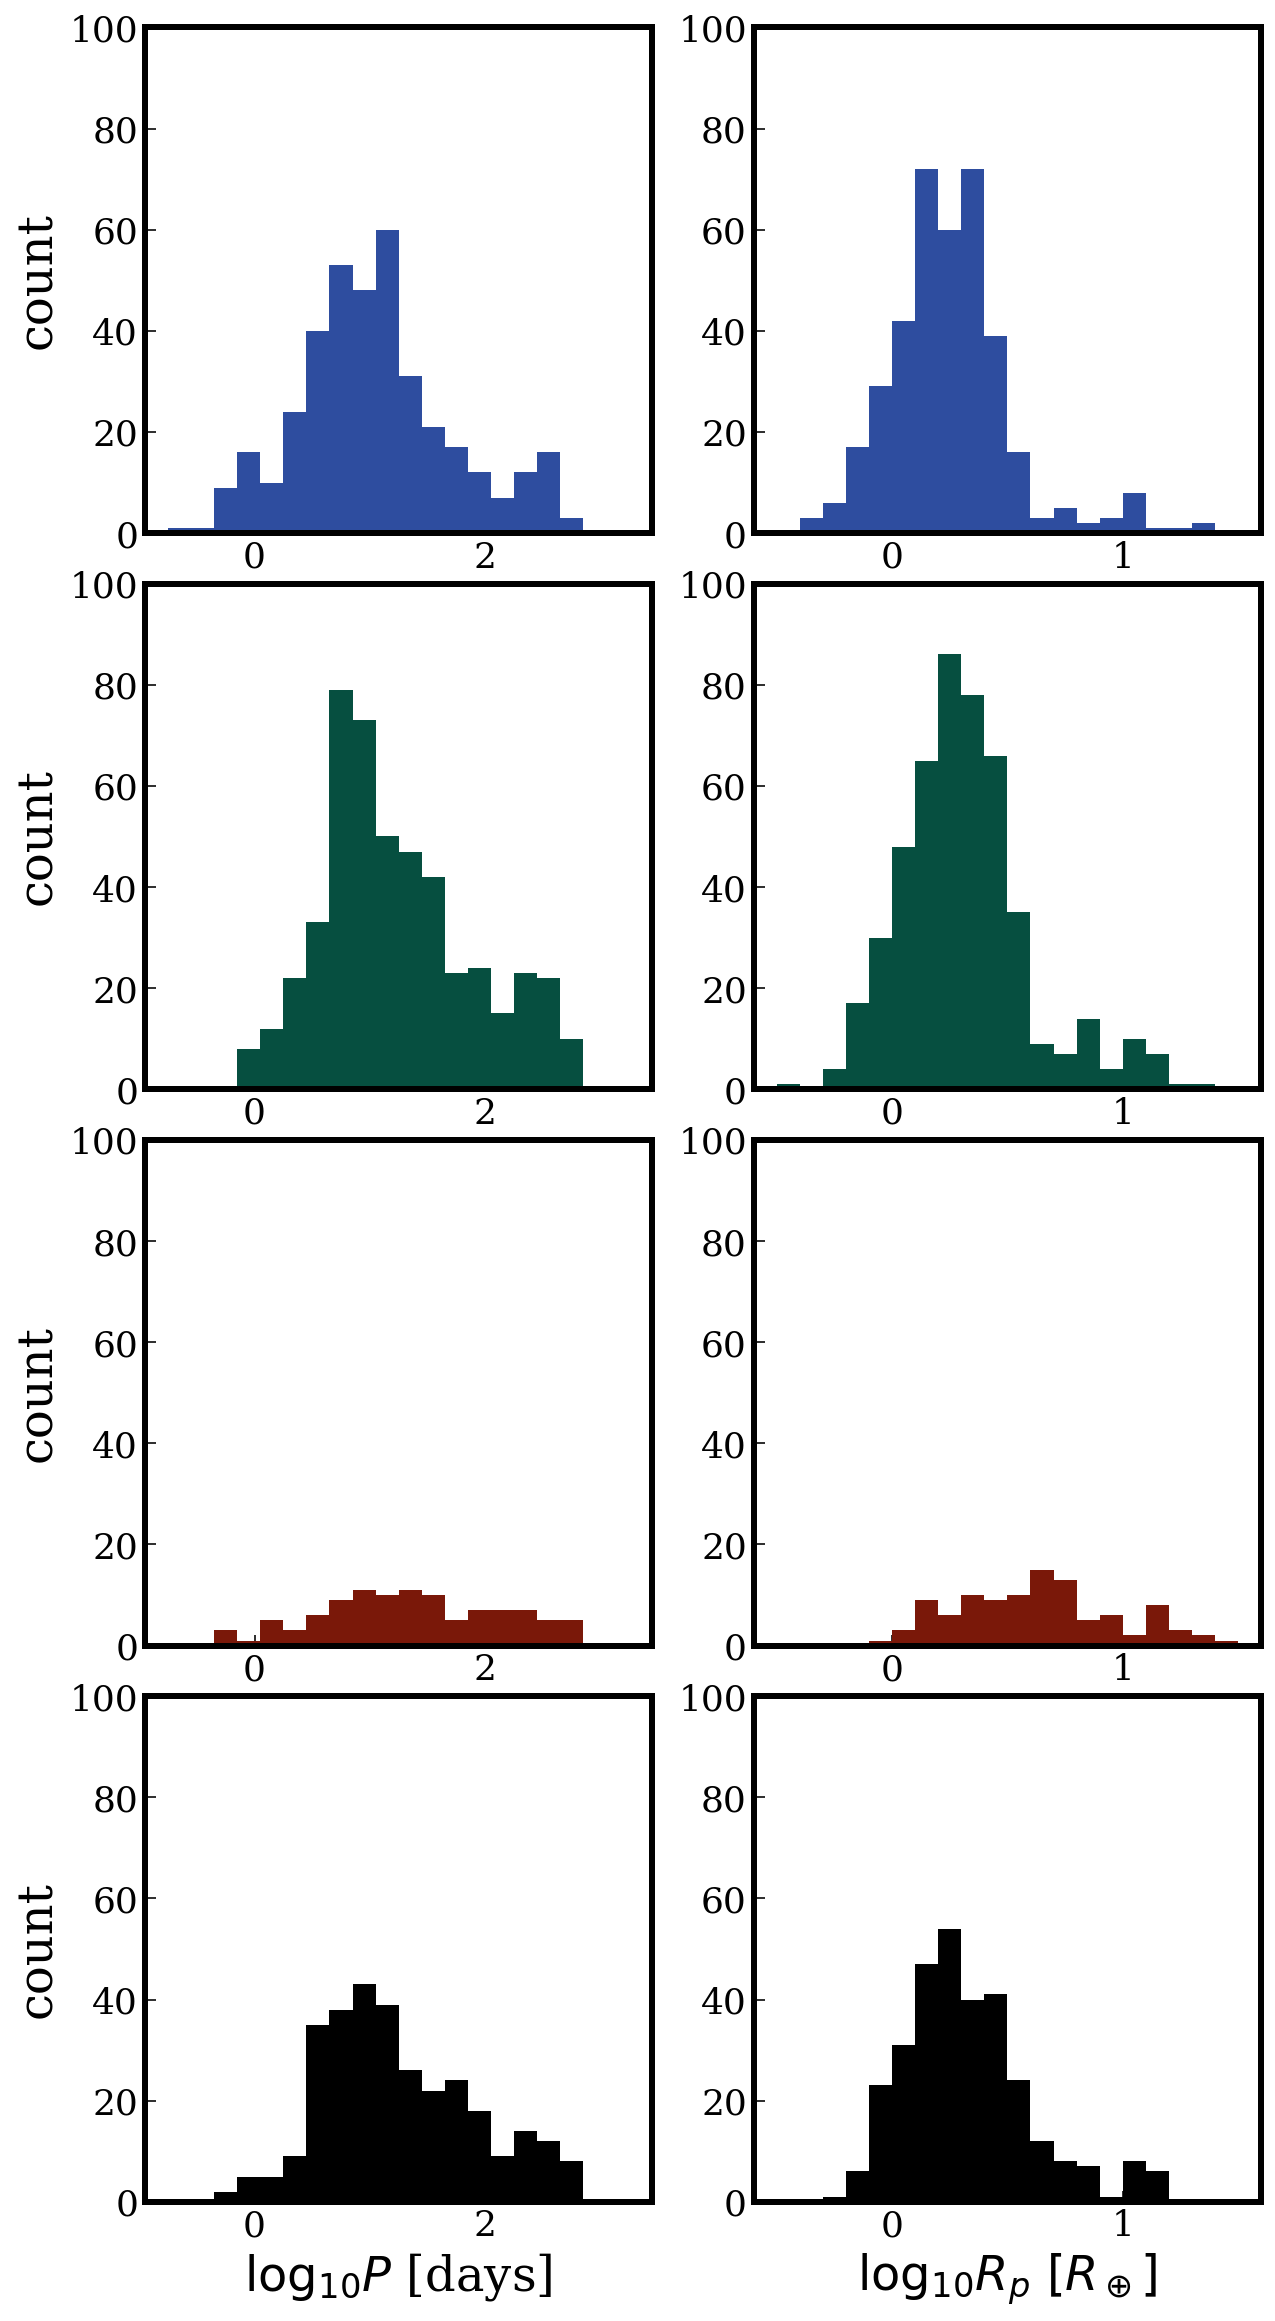

In [240]:
# Histograms of planet properties by system type

classes = np.atleast_1d(np.array((7)))
# optimal seeds
#seeds = np.argmin(loss_arr,axis=1)
seeds = np.atleast_1d(np.array((3)))

for n_idx in np.arange(len(classes)):
#for n_idx in np.arange(1):
    n_classes = classes[n_idx]
    seed = seeds[n_idx]

    print("n_classes is {0}".format(n_classes))
    
    resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

    logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)
    
    # constraints colnames:
    # kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

    CVdata = np.zeros((1,n_features+1))
    #CVconstraints = np.zeros((1,11))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-1] = np.array(sys[j])
            row[-1] = ID
            CVdata = np.vstack((CVdata,row))
        # organize constraints in the same order
        '''
        for j in range(1,len(sys)):
            c_row = np.zeros_like(CVconstraints[0])
            sys_constraints_mask = (constraints[:,0] == ID)
            sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
            #print(ID)
            #print(len(sys)-1)
            for c in sys_constraints_idxs:
                if constraints[c,1] == j-1:
                    #print(constraints[c])
                    c_row[:] = constraints[c,3:]
                
            CVconstraints = np.vstack((CVconstraints,c_row))
        '''
    CVdata = CVdata[1:]
    #CVconstraints = CVconstraints[1:]
    
    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
        mults[i] = int(len(CVdata[thisSystemMask]))
    
    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    print(np.shape(CVdata))
    #columns of CVdata: log10Rp, log10P, Teff, logg, kepID, mult
    
    losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
    CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
    CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
    CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))
    
    CVdata = CVdata[CVidxs]
    #CVconstraints = CVconstraints[CVidxs]
    
    CVbestClass = np.argmax(CVresults,axis=1)
    CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)
    
    # TRUTHS and RESULTS
    arrays_ = [CVbestClass,CVbestClass_fromContext]
    titles_ = ["Best", "Best from context"]
    plotTitles_ = ["results","results_fromcontext"]
    
    for m in [1]:
        print("mult is {0}".format(m))
        CVdata_toplot = CVdata
        print(np.shape(CVdata_toplot))
        array1 = CVbestClass
        array2 = CVbestClass_fromContext
        
        #type A, B, C, or borderline systems
        typeAidxs = []
        typeBidxs = []
        typeCidxs = []
        borderlineidxs = []
        
        for i, ID in enumerate(CVdata_toplot[:,-2]):
            thisSysMask = (CVdata_toplot[:,-2] == ID)
            thisSysIdxs = np.arange(len(CVdata_toplot[:,-2]))[thisSysMask]
            
            thisTeff = ((CVdata_toplot[:,2][thisSysMask][0])*sigmas[2]) + mus[2]
            thislogg = ((CVdata_toplot[:,3][thisSysMask][0])*sigmas[3]) + mus[3]
            
            if (thisTeff < 5500.) & (thislogg > 4.4):
                typeAidxs.extend(thisSysIdxs)
            elif (thisTeff > 5700.) & (thislogg > 4.2):
                typeBidxs.extend(thisSysIdxs)
            elif (thislogg < 4.0):
                typeCidxs.extend(thisSysIdxs)
            else:
                borderlineidxs.extend(thisSysIdxs)
            #print(CVdata_toplot[:,2][thisSysMask])
            
        typeAidxs = np.unique(np.array(typeAidxs))
        typeBidxs = np.unique(np.array(typeBidxs))
        typeCidxs = np.unique(np.array(typeCidxs))
        borderlineidxs = np.unique(np.array(borderlineidxs))
        
        Rs = (CVdata_toplot[:,0]*sigmas[0])+mus[0]
        Ps = (CVdata_toplot[:,1]*sigmas[1])+mus[1]
        
        idxs_ = [typeAidxs,typeBidxs,typeCidxs,borderlineidxs]
        histcolors = ['#2e4d9f','#064f40','#7a1809','#000000']
        
        fig, axes = plt.subplots(4,2,figsize=(10,20))
    
        for i in range(4):
            axes[i,0].hist(Ps[idxs_[i]], range=(-0.75,3.25),bins=20,color=histcolors[i],lw=2,alpha=1)
            axes[i,1].hist(Rs[idxs_[i]], range=(-0.5,1.5),bins=20,color=histcolors[i],lw=2,alpha=1)
            axes[i,0].set_ylabel('count',fontsize=24)
            axes[i,0].tick_params(labelsize=18)
            axes[i,1].tick_params(labelsize=18)
            axes[i,0].set_ylim(0,100)
            axes[i,1].set_ylim(0,100)
        axes[3,0].set_xlabel(r'$\log_{10}P$ [days]',fontsize=24)
        axes[3,1].set_xlabel(r'$\log_{10}R_p\ [R_\oplus]$',fontsize=24)
        plt.subplots_adjust(wspace=0.2,hspace=0.1)

        #plt.show()
        plt.savefig("{0}/realKOIs_finalFeatures_incJ_30percent_{1}classes_{2}_{3}_typehistograms.pdf".format(resultsFolder,n_classes,plotTitles_[h],seed),fmt="pdf",bbox_inches="tight")
        
    

# Get persistent groupings more quantitatively

In [108]:
classes = np.arange(2,11)
# optimal seeds
seeds = np.argmin(loss_arr,axis=1)

likeRandomPlanet_fromTarget = np.empty((len(CVdata), len(CVdata)))
likeRandomPlanet_fromContext = np.empty((len(CVdata), len(CVdata)))

for ri in np.arange(len(CVdata)):
    print("ri is {0}".format(ri))
    
    likeRandomPlanetIdxs = np.arange(len(CVdata),dtype=float)
    likeRandomPlanetIdxs_fc = np.arange(len(CVdata),dtype=float)


    for n_idx in np.arange(len(classes)):
        n_classes = classes[n_idx]
        #print("n_classes is {0}".format(n_classes))
        seed = seeds[n_idx]
    
        # get CV data
        with open(CVDataFile, "rb") as picklefile:
            testSystems = pickle.load(picklefile)


        CVdata = np.zeros((1,n_features+2))

        for i in range(len(testSystems)):
            sys = testSystems[i]
            ID = sys[0]
            for j in range(1,len(sys)):
                row = np.zeros_like(CVdata[0])
                row[:-2] = np.array(sys[j])
                row[-2] = ID
                CVdata = np.vstack((CVdata,row))

        CVdata = CVdata[1:]
        CVdata[:,-1] = np.arange(0,len(CVdata))#planet indices

        mults = np.zeros_like(CVdata[:,0])
        for i in range(len(CVdata)):
            thisSystemMask = (CVdata[:,-2] == CVdata[i,-2])
            mults[i] = int(len(CVdata[thisSystemMask]))

        CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))

        CVdata_toplot = np.zeros_like(CVdata)
        CVdata_toplot[:,0] = CVdata[:,1]
        CVdata_toplot[:,1] = CVdata[:,0]
        CVdata_toplot[:,2] = CVdata[:,2]
        CVdata_toplot[:,3] = CVdata[:,3]
        CVdata_toplot[:,4] = CVdata[:,4]
        CVdata_toplot[:,5] = CVdata[:,5]

        mus_swapped = np.zeros_like(mus)
        mus_swapped[0] = mus[1]
        mus_swapped[1] = mus[0]
        mus_swapped[2] = mus[2]
        mus_swapped[3] = mus[3]

        sigmas_swapped = np.std(features,axis=0)
        sigmas_swapped[0] = sigmas[1]
        sigmas_swapped[1] = sigmas[0]
        sigmas_swapped[2] = sigmas[2]
        sigmas_swapped[3] = sigmas[3]
        
        labels_swapped = [r'$\log_{10}P$ [days]',r'$\log_{10}R_p\ [R_\oplus]$',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
        lims_swapped = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
        scatterlims_swapped = [(-0.75,3.25),(-0.5,1.5),(4000,7000),(3.0,4.8)]

        #print("n_idx is {0}".format(n_idx))
        #print("n_classes is {0}".format(n_classes))

        resultsFolder = "./realPlanets_incJ_final/{0}classes".format(n_classes)

        logfile = "{0}/realKOIs_finalFeatures_incJ_{1}classes.log".format(resultsFolder,n_classes)

        losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
        CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_softmax_{1}.npy".format(resultsFolder,seed))
        CVresults_fromContext = np.exp(np.load("{0}/realKOIs_finalFeatures_incJ_30percent_classprobs_fromcontext_logsoftmax_{1}.npy".format(resultsFolder,seed)))
        CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))
        
        #reshuffle CVdata s.t. you can match it with classifications
        CVdata = CVdata[CVidxs]
        CVdata_toplot = CVdata_toplot[CVidxs]

        CVbestClass = np.argmax(CVresults,axis=1)
        CVbestClass_fromContext = np.argmax(CVresults_fromContext,axis=1)
        
        #get planets that are grouped with this planet
        thisRandomPlanetMask = (CVdata[:,-2] == ri)
        thisRandomPlanetClass = CVbestClass[thisRandomPlanetMask]
        likeThisPlanetMask = (CVbestClass == thisRandomPlanetClass)
        likeThisPlanetIDs = CVdata[:,-2][likeThisPlanetMask]
        likeThisPlanet = np.intersect1d(likeRandomPlanetIdxs,likeThisPlanetIDs)
        likeRandomPlanetIdxs = likeThisPlanet
        
        thisRandomPlanetClass_fc = CVbestClass_fromContext[thisRandomPlanetMask]
        likeThisPlanetMask_fc = (CVbestClass_fromContext == thisRandomPlanetClass_fc)
        likeThisPlanetIDs_fc = CVdata[:,-2][likeThisPlanetMask_fc]
        likeThisPlanet_fc = np.intersect1d(likeRandomPlanetIdxs_fc,likeThisPlanetIDs_fc)
        likeRandomPlanetIdxs_fc = likeThisPlanet_fc
    
    likeRandomPlanetIdxs = likeRandomPlanetIdxs.astype(int)
    likeRandomPlanetIdxs_fc = likeRandomPlanetIdxs_fc.astype(int)
    
    targ = [True if idx in likeRandomPlanetIdxs else False for idx in range(len(CVdata))]
    cont = [True if idx in likeRandomPlanetIdxs_fc else False for idx in range(len(CVdata))]
    likeRandomPlanet_fromTarget[ri] = np.array(targ)
    likeRandomPlanet_fromContext[ri] = np.array(cont)
    
    

ri is 0
ri is 1
ri is 2
ri is 3
ri is 4
ri is 5
ri is 6
ri is 7
ri is 8
ri is 9
ri is 10
ri is 11
ri is 12
ri is 13
ri is 14
ri is 15
ri is 16
ri is 17
ri is 18
ri is 19
ri is 20
ri is 21
ri is 22
ri is 23
ri is 24
ri is 25
ri is 26
ri is 27
ri is 28
ri is 29
ri is 30
ri is 31
ri is 32
ri is 33
ri is 34
ri is 35
ri is 36
ri is 37
ri is 38
ri is 39
ri is 40
ri is 41
ri is 42
ri is 43
ri is 44
ri is 45
ri is 46
ri is 47
ri is 48
ri is 49
ri is 50
ri is 51
ri is 52
ri is 53
ri is 54
ri is 55
ri is 56
ri is 57
ri is 58
ri is 59
ri is 60
ri is 61
ri is 62
ri is 63
ri is 64
ri is 65
ri is 66
ri is 67
ri is 68
ri is 69
ri is 70
ri is 71
ri is 72
ri is 73
ri is 74
ri is 75
ri is 76
ri is 77
ri is 78
ri is 79
ri is 80
ri is 81
ri is 82
ri is 83
ri is 84
ri is 85
ri is 86
ri is 87
ri is 88
ri is 89
ri is 90
ri is 91
ri is 92
ri is 93
ri is 94
ri is 95
ri is 96
ri is 97
ri is 98
ri is 99
ri is 100
ri is 101
ri is 102
ri is 103
ri is 104
ri is 105
ri is 106
ri is 107
ri is 108
ri is 109
ri is 110


ri is 831
ri is 832
ri is 833
ri is 834
ri is 835
ri is 836
ri is 837
ri is 838
ri is 839
ri is 840
ri is 841
ri is 842
ri is 843
ri is 844
ri is 845
ri is 846
ri is 847
ri is 848
ri is 849
ri is 850
ri is 851
ri is 852
ri is 853
ri is 854
ri is 855
ri is 856
ri is 857
ri is 858
ri is 859
ri is 860
ri is 861
ri is 862
ri is 863
ri is 864
ri is 865
ri is 866
ri is 867
ri is 868
ri is 869
ri is 870
ri is 871
ri is 872
ri is 873
ri is 874
ri is 875
ri is 876
ri is 877
ri is 878
ri is 879
ri is 880
ri is 881
ri is 882
ri is 883
ri is 884
ri is 885
ri is 886
ri is 887
ri is 888
ri is 889
ri is 890
ri is 891
ri is 892
ri is 893
ri is 894
ri is 895
ri is 896
ri is 897
ri is 898
ri is 899
ri is 900
ri is 901
ri is 902
ri is 903
ri is 904
ri is 905
ri is 906
ri is 907
ri is 908
ri is 909
ri is 910
ri is 911
ri is 912
ri is 913
ri is 914
ri is 915
ri is 916
ri is 917
ri is 918
ri is 919
ri is 920
ri is 921
ri is 922
ri is 923
ri is 924
ri is 925
ri is 926
ri is 927
ri is 928
ri is 929
ri is 930


In [126]:
print(likeRandomPlanet_fromTarget)
print(np.shape(likeRandomPlanet_fromTarget))

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 1.]]
(1278, 1278)


In [109]:
likeRandomPlanet_targ, likeRandomPlanet_targ_idxs = np.unique(likeRandomPlanet_fromTarget,axis=0,return_index=True)
likeRandomPlanet_cont, likeRandomPlanet_cont_idxs = np.unique(likeRandomPlanet_fromContext,axis=0,return_index=True)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 1.]]


In [110]:
print(np.shape(likeRandomPlanet_targ))
print(np.shape(likeRandomPlanet_cont))

print(1278/10)

(150, 1278)
(279, 1278)
127.8


In [155]:
for ui in np.arange(len(likeRandomPlanet_targ)):
    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)


    CVdata = np.zeros((1,n_features+2))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-2] = np.array(sys[j])
            row[-2] = ID
            CVdata = np.vstack((CVdata,row))

    CVdata = CVdata[1:]
    CVdata[:,-1] = np.arange(0,len(CVdata))#planet indices

    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-2] == CVdata[i,-2])
        mults[i] = int(len(CVdata[thisSystemMask]))

    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))

    CVdata_toplot = np.zeros_like(CVdata)
    CVdata_toplot[:,0] = CVdata[:,1]
    CVdata_toplot[:,1] = CVdata[:,0]
    CVdata_toplot[:,2] = CVdata[:,2]
    CVdata_toplot[:,3] = CVdata[:,3]
    CVdata_toplot[:,4] = CVdata[:,4]
    CVdata_toplot[:,5] = CVdata[:,5]
    
    thisGroupMask = likeRandomPlanet_targ[ui].astype(bool)
    
    if len(np.arange(len(CVdata))[thisGroupMask]) > 32:
        print(ui)
    
        fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
        gs = gridspec.GridSpec(n_planet_features, n_planet_features)

        for i in range(n_planet_features):
            for j in range(n_planet_features):

                if i>j:
                    ax = plt.subplot(gs[i,j])


                    xdata=((CVdata_toplot[:,0]*sigmas_swapped[0])+mus_swapped[0])
                    ydata=((CVdata_toplot[:,1]*sigmas_swapped[1])+mus_swapped[1])

                    ax.plot(xdata,ydata,'k.',ls='None')
                    ax.plot(xdata[thisGroupMask],ydata[thisGroupMask],'r.',ls='None')

                    ax.set_xlim(scatterlims_swapped[0])
                    ax.set_ylim(scatterlims_swapped[1])

        plt.savefig("realPlanets_incJ_final/persistentGroupings_upto10/planetFeatures_{0}.pdf".format(ui),fmt="pdf",bbox_inches="tight")
        plt.close()


133
138
140
141
147
148
149


In [136]:
print(likeRandomPlanet_targ_idxs[147])
print(likeRandomPlanet_targ_idxs[148])
print(likeRandomPlanet_targ_idxs[149])

2
1
0


In [156]:
for ui in np.arange(len(likeRandomPlanet_cont)):
    # get CV data
    with open(CVDataFile, "rb") as picklefile:
        testSystems = pickle.load(picklefile)


    CVdata = np.zeros((1,n_features+2))

    for i in range(len(testSystems)):
        sys = testSystems[i]
        ID = sys[0]
        for j in range(1,len(sys)):
            row = np.zeros_like(CVdata[0])
            row[:-2] = np.array(sys[j])
            row[-2] = ID
            CVdata = np.vstack((CVdata,row))

    CVdata = CVdata[1:]
    CVdata[:,-1] = np.arange(0,len(CVdata))#planet indices

    mults = np.zeros_like(CVdata[:,0])
    for i in range(len(CVdata)):
        thisSystemMask = (CVdata[:,-2] == CVdata[i,-2])
        mults[i] = int(len(CVdata[thisSystemMask]))

    CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))

    CVdata_toplot = np.zeros_like(CVdata)
    CVdata_toplot[:,0] = CVdata[:,1]
    CVdata_toplot[:,1] = CVdata[:,0]
    CVdata_toplot[:,2] = CVdata[:,2]
    CVdata_toplot[:,3] = CVdata[:,3]
    CVdata_toplot[:,4] = CVdata[:,4]
    CVdata_toplot[:,5] = CVdata[:,5]
    
    thisGroupMask = likeRandomPlanet_cont[ui].astype(bool)
    
    if len(np.arange(len(CVdata))[thisGroupMask]) > 32:
        print(ui)
    
        fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
        gs = gridspec.GridSpec(n_planet_features, n_planet_features)

        for i in range(n_planet_features):
            for j in range(n_planet_features):

                if i>j:
                    ax = plt.subplot(gs[i,j])   
                    xdata=((CVdata_toplot[:,2]*sigmas_swapped[2])+mus_swapped[2])
                    ydata=((CVdata_toplot[:,3]*sigmas_swapped[3])+mus_swapped[3])

                    ax.plot(xdata,ydata,'k.',ms=5,ls='None')
                    ax.plot(xdata[thisGroupMask],ydata[thisGroupMask],'r.',ms=3,ls='None')

                    ax.set_xlim(scatterlims_swapped[2])
                    ax.set_ylim(scatterlims_swapped[3])
                    ax.invert_yaxis()
                    ax.invert_xaxis()
        plt.savefig("realPlanets_incJ_final/persistentGroupings_upto10/stellarFeatures_{0}.pdf".format(ui),fmt="pdf",bbox_inches="tight")
        plt.close()

266
272
274
275
276
277
278


In [130]:
print(likeRandomPlanet_cont_idxs[266])
print(likeRandomPlanet_cont_idxs[272])
print(likeRandomPlanet_cont_idxs[274])
print(likeRandomPlanet_cont_idxs[275])
print(likeRandomPlanet_cont_idxs[276])
print(likeRandomPlanet_cont_idxs[277])

24
6
4
3
2
1


In [119]:
32/1278

0.025039123630672927

In [167]:
planetGroupSizes = np.array([np.sum(likeRandomPlanet_targ[i]) for i in range(len(likeRandomPlanet_targ))])
starGroupSizes = np.array([np.sum(likeRandomPlanet_cont[i]) for i in range(len(likeRandomPlanet_cont))])

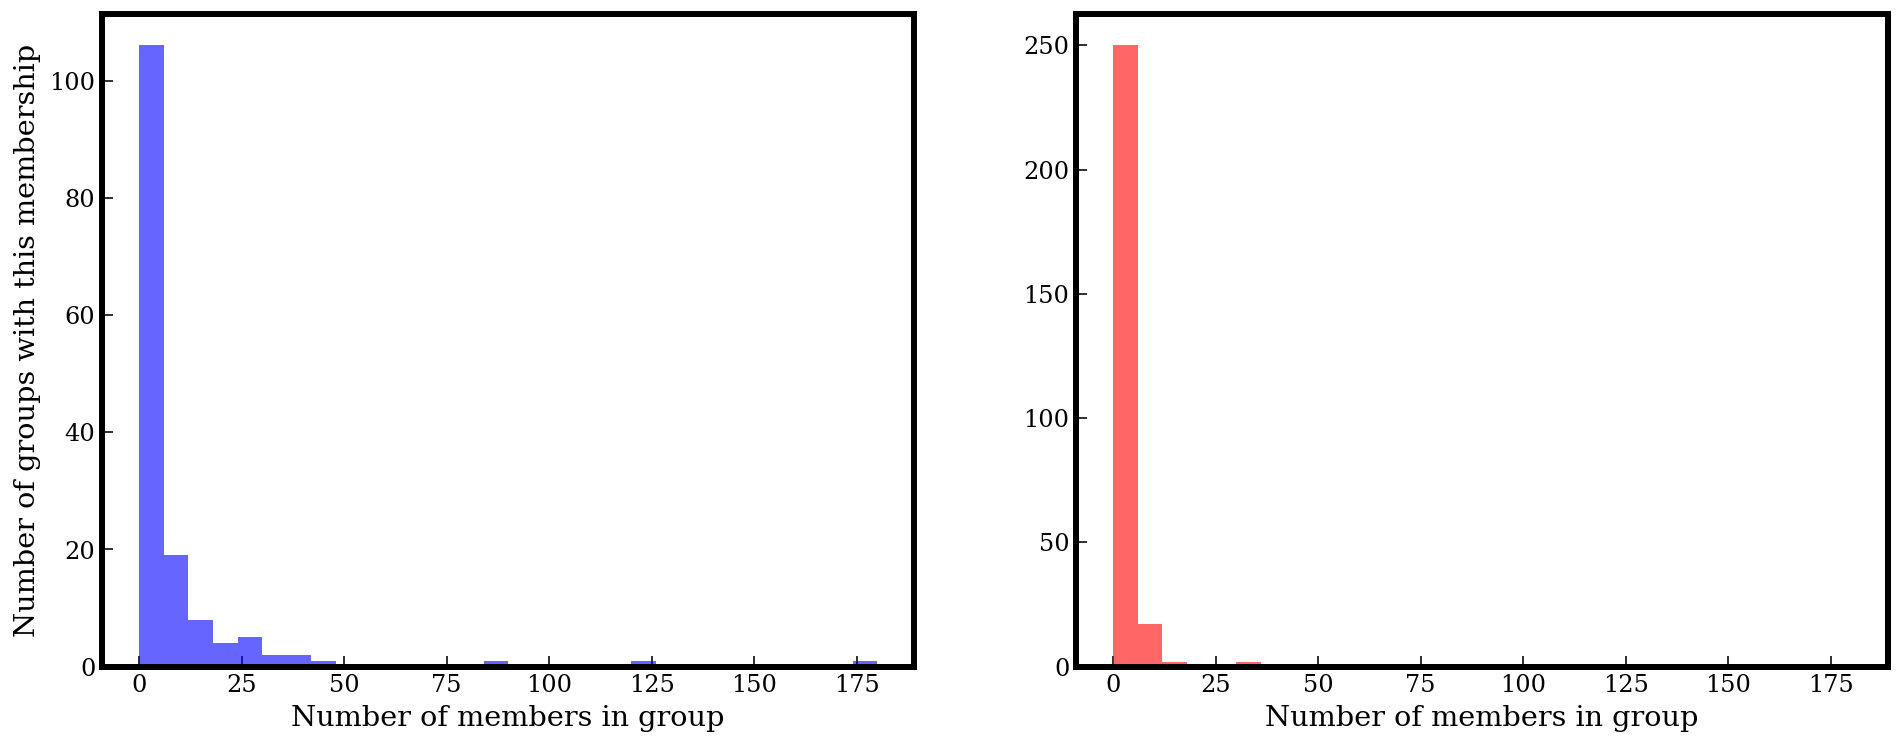

In [172]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].hist(planetGroupSizes,bins=30,range=(0,180),color='b',alpha=0.6)
axes[1].hist(starGroupSizes,bins=30,range=(0,180),color='r',alpha=0.6)
axes[0].set_xlabel("Number of members in group")
axes[1].set_xlabel("Number of members in group")
axes[0].set_ylabel("Number of groups with this membership")
plt.show()

In [169]:
# get the indices in the right order

# likeRandomPlanet_fromTarget = (1278,1278)
# likeRandomPlanet_fromContext = (1278,1278) #each row is an array of 0s and 1s. the 1s in row i = planets which are never separated from planet i

# likeRandomPlanet_targ = (150,1278) = the 150 unique entries in likeRandomPlanet_fromTarget, i.e. the 150 unique groupings identified by the target network
# likeRandomPlanet_cont = (279,1278) = the 279 unique entries in likeRandomPlanet_fromContext, i.e. the 279 unique groupings identified by the context network

# likeRandomPlanet_targ_idxs = (150) = the indices into likeRandomPlanet_fromTarget that yield the 150 unique entries
# likeRandomPlanet_cont_idxs = (150) = the indices into likeRandomPlanet_fromContext that yield the 279 unique entries

# planetGroupSizes = (150) = the number of planets in each of the 150 target-network groups
# starGroupSizes = (279) = the number of planets in each of the 279 context-network groups


planetSizeIdxs = np.argsort(planetGroupSizes)[::-1]
getPlanetGroupsBySize = likeRandomPlanet_targ_idxs[planetSizeIdxs]

starSizeIdxs = np.argsort(starGroupSizes)[::-1]
getStarGroupsBySize =  likeRandomPlanet_cont_idxs[starSizeIdxs]


In [173]:
planetGroupSizes = planetGroupSizes[planetSizeIdxs]
starGroupSizes = starGroupSizes[starSizeIdxs]
print(planetGroupSizes)
print(starGroupSizes)

[176. 124.  89.  46.  41.  39.  34.  30.  29.  27.  26.  26.  26.  21.
  19.  19.  19.  17.  17.  16.  14.  14.  13.  13.  12.  11.  11.  11.
  10.   9.   9.   9.   9.   9.   8.   8.   7.   6.   6.   6.   6.   6.
   6.   6.   5.   5.   5.   5.   5.   5.   5.   4.   4.   4.   4.   4.
   4.   4.   4.   4.   4.   3.   3.   3.   3.   3.   3.   3.   3.   3.
   3.   3.   3.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.   2.
   2.   2.   2.   2.   2.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.]
[175. 114. 107.  97.  66.  64.  34.  32.  24.  18.  12.  12.  11.  11.
  11.  11.  11.  10.  10.   9.   8.   7.   7.   6.   6.   6.   6.   6.
   6.   5.   5.   5.   5.   4.   4.   4.   4.   4.   4.   4.   4.   4.
   4.   3.   3.   3.   3.

# Redo figures 10 onward (persistent groupings & system grammar) on this new basis

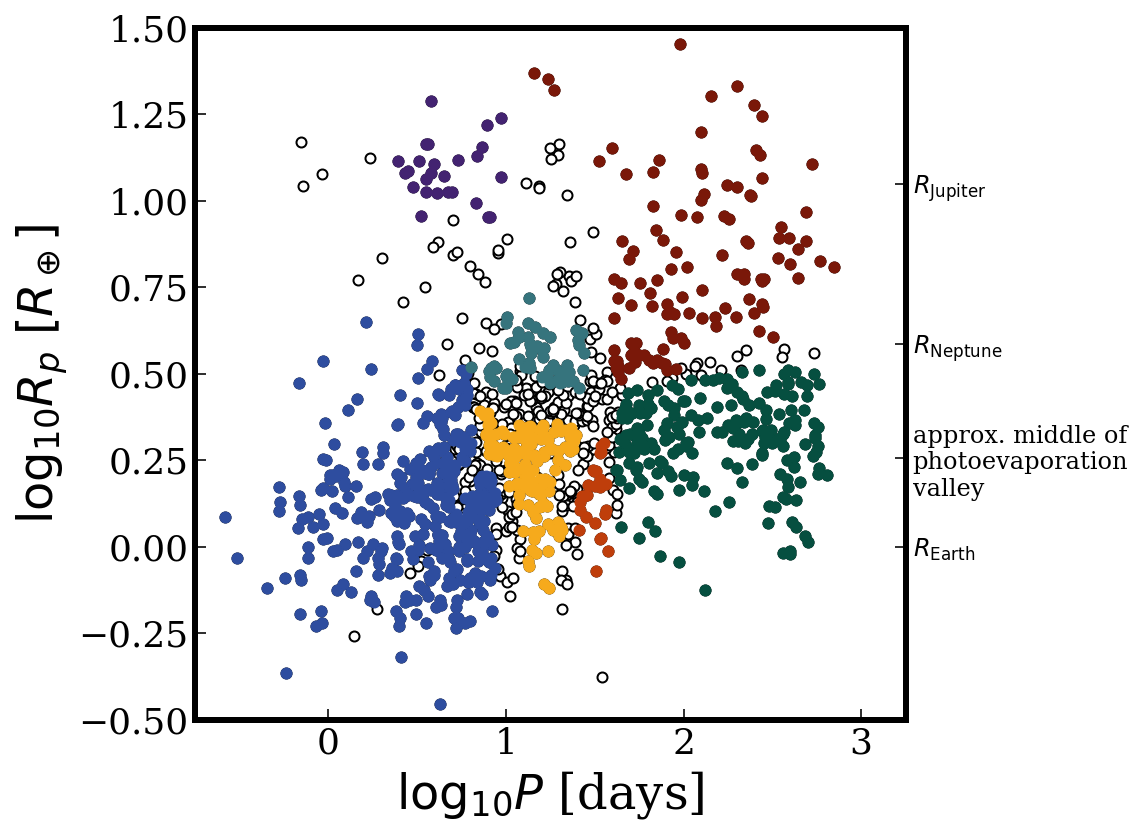

In [407]:
classColoursList = ['#36747d','#f6aa1c','#7a1809','#003049','#2e4d9f',
                    '#bf3e0b','#064f40','#432371','#007f5f','#613dc1']

planetGroups_classColoursList = ['#2e4d9f','#064f40','#7a1809','#36747d','#2e4d9f',
                                 '#f6aa1c','#2e4d9f','#f6aa1c','#2e4d9f','#f6aa1c',
                                 '#bf3e0b','#064f40','#7a1809','#064f40','#f6aa1c',
                                 '#f6aa1c','#2e4d9f','#2e4d9f','#2e4d9f','#432371',
                                 '#2e4d9f','#2e4d9f','#064f40','#36747d','#2e4d9f',
                                 '#f6aa1c','#2e4d9f','#064f40','#432371']


t1color = '#2e4d9f'
t2color = '#f6aa1c'
t3color = '#bf3e0b'
t4color = '#36747d'
t5color = '#064f40'
t6color = '#7a1809'
t7color = '#432371'


# planets plot

with open(CVDataFile, "rb") as picklefile:
    testSystems = pickle.load(picklefile)


CVdata = np.zeros((1,n_features+2))

for i in range(len(testSystems)):
    sys = testSystems[i]
    ID = sys[0]
    for j in range(1,len(sys)):
        row = np.zeros_like(CVdata[0])
        row[:-2] = np.array(sys[j])
        row[-2] = ID
        CVdata = np.vstack((CVdata,row))

CVdata = CVdata[1:]
CVdata[:,-1] = np.arange(0,len(CVdata))#planet indices

mults = np.zeros_like(CVdata[:,0])
for i in range(len(CVdata)):
    thisSystemMask = (CVdata[:,-2] == CVdata[i,-2])
    mults[i] = int(len(CVdata[thisSystemMask]))

CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))

CVdata_toplot = np.zeros_like(CVdata)
CVdata_toplot[:,0] = CVdata[:,1]
CVdata_toplot[:,1] = CVdata[:,0]
CVdata_toplot[:,2] = CVdata[:,2]
CVdata_toplot[:,3] = CVdata[:,3]
CVdata_toplot[:,4] = CVdata[:,4]
CVdata_toplot[:,5] = CVdata[:,5] #planet idx
CVdata_toplot[:,6] = CVdata[:,6] #mult

planetType = np.zeros_like(CVdata_toplot[:,5])

fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
gs = gridspec.GridSpec(n_planet_features, n_planet_features)

for i in range(n_planet_features):
    for j in range(n_planet_features):

        if i>j:
            ax = plt.subplot(gs[i,j])   
            xdata=((CVdata_toplot[:,0]*sigmas_swapped[0])+mus_swapped[0])
            ydata=((CVdata_toplot[:,1]*sigmas_swapped[1])+mus_swapped[1])

            ax.plot(xdata,ydata,color='#ffffff',marker='.',mec='k',ms=10,lw=1,ls='None')
            
            #for k in range(3): #groups >= 50
            #for k in range(14): #groups >= 20
            for k in range(29): #groups >= 10
            #for k in range(51): #groups >= 5
                thisGroupMask = likeRandomPlanet_fromTarget[getPlanetGroupsBySize[k]].astype(bool)
                ax.plot(xdata[thisGroupMask],ydata[thisGroupMask],marker='.',color=planetGroups_classColoursList[k],ms=10,ls='None')
                
                if planetGroups_classColoursList[k] == t1color:
                    planetType[thisGroupMask] = 1
                elif planetGroups_classColoursList[k] == t2color:
                    planetType[thisGroupMask] = 2
                elif planetGroups_classColoursList[k] == t3color:
                    planetType[thisGroupMask] = 3
                elif planetGroups_classColoursList[k] == t4color:
                    planetType[thisGroupMask] = 4
                elif planetGroups_classColoursList[k] == t5color:
                    planetType[thisGroupMask] = 5
                elif planetGroups_classColoursList[k] == t6color:
                    planetType[thisGroupMask] = 6
                elif planetGroups_classColoursList[k] == t7color:
                    planetType[thisGroupMask] = 7
                
            ax.set_xlim(scatterlims_swapped[0])
            ax.set_ylim(scatterlims_swapped[1])
            #ax.invert_yaxis()
            #ax.invert_xaxis()
            
            ax.set_xlabel(labels_swapped[0],fontsize=24)
            ax.set_ylabel(labels_swapped[1],fontsize=24)
            ax.tick_params(labelsize=18)
            #ax.set_xticklabels([])
            ylabelplot = ax.twinx()
            ylabelplot.grid(False)
            ylabelplot.set_ylim(scatterlims_swapped[1])
            ylabelplot.set_yticks(np.log10(np.array((1.0,1.8,3.86,11.2))))
            ylabelplot.set_yticklabels([r'$R_{\mathrm{Earth}}$','approx. middle of\nphotoevaporation\nvalley',r'$R_{\mathrm{Neptune}}$',r'$R_{\mathrm{Jupiter}}$'])
    
plt.savefig("realPlanets_incJ_final/persistentGroupings_upto10/planetFeatures_groups>=10_orgColor.pdf",fmt="pdf",bbox_inches="tight")
#plt.close()
#plt.show()

In [408]:
print(planetType)

[5. 1. 6. ... 5. 2. 6.]


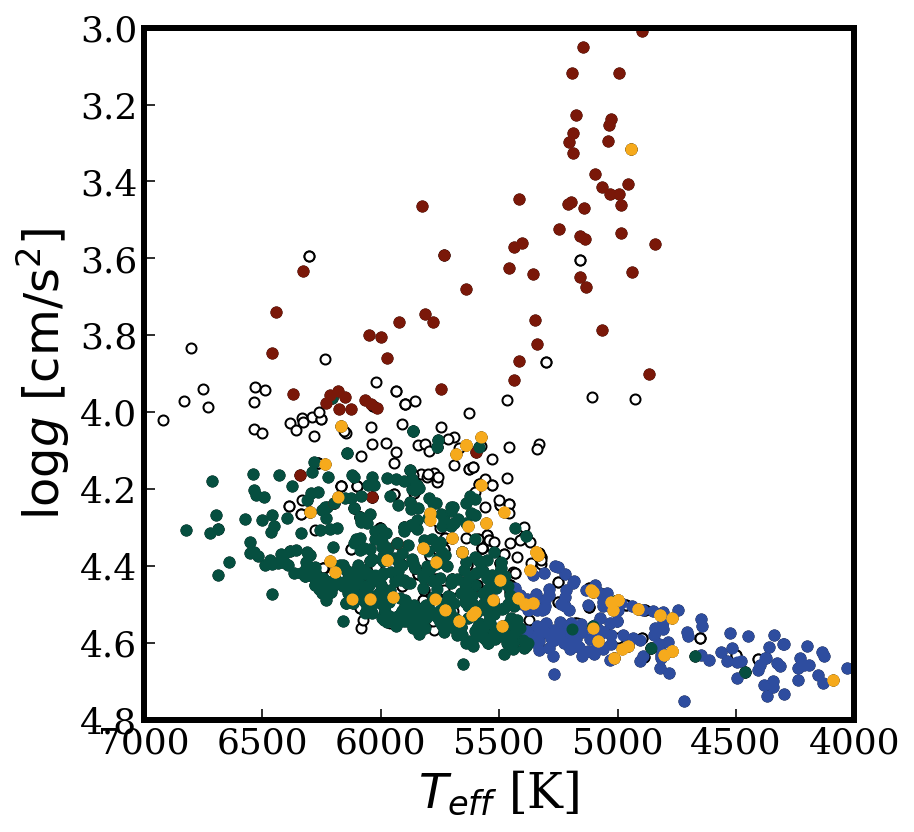

In [409]:
# stars plot

classColoursList = ['#36747d','#f6aa1c','#7a1809','#003049','#2e4d9f',
                    '#bf3e0b','#064f40','#432371','#007f5f','#613dc1']

starGroups_classColoursList = ['#2e4d9f','#064f40','#064f40','#064f40','#7a1809',
                                '#f6aa1c','#064f40','#064f40','#2e4d9f','#064f40',
                                '#064f40','#064f40','#064f40','#064f40','#064f40',
                                '#064f40','#064f40','#064f40','#7a1809',]

with open(CVDataFile, "rb") as picklefile:
    testSystems = pickle.load(picklefile)


CVdata = np.zeros((1,n_features+2))

for i in range(len(testSystems)):
    sys = testSystems[i]
    ID = sys[0]
    for j in range(1,len(sys)):
        row = np.zeros_like(CVdata[0])
        row[:-2] = np.array(sys[j])
        row[-2] = ID
        CVdata = np.vstack((CVdata,row))

CVdata = CVdata[1:]
CVdata[:,-1] = np.arange(0,len(CVdata))#planet indices

mults = np.zeros_like(CVdata[:,0])
for i in range(len(CVdata)):
    thisSystemMask = (CVdata[:,-2] == CVdata[i,-2])
    mults[i] = int(len(CVdata[thisSystemMask]))

CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))

CVdata_toplot = np.zeros_like(CVdata)
CVdata_toplot[:,0] = CVdata[:,1]
CVdata_toplot[:,1] = CVdata[:,0]
CVdata_toplot[:,2] = CVdata[:,2]
CVdata_toplot[:,3] = CVdata[:,3]
CVdata_toplot[:,4] = CVdata[:,4]
CVdata_toplot[:,5] = CVdata[:,5]

fig = plt.figure(figsize=(7*n_planet_features,7*n_planet_features))
gs = gridspec.GridSpec(n_planet_features, n_planet_features)

for i in range(n_planet_features):
    for j in range(n_planet_features):

        if i>j:
            ax = plt.subplot(gs[i,j])   
            xdata=((CVdata_toplot[:,2]*sigmas_swapped[2])+mus_swapped[2])
            ydata=((CVdata_toplot[:,3]*sigmas_swapped[3])+mus_swapped[3])

            ax.plot(xdata,ydata,color='#ffffff',marker='.',mec='k',ms=10,lw=1,ls='None')
            
            #for k in range(6): #groups >= 50
            #for k in range(9): #groups >= 20
            for k in range(19): #groups >= 10
            #for k in range(33): #groups >= 5
                thisGroupMask = likeRandomPlanet_fromContext[getStarGroupsBySize[k]].astype(bool)
                ax.plot(xdata[thisGroupMask],ydata[thisGroupMask],marker='.',color=starGroups_classColoursList[k],ms=10,ls='None')
            for k in range(5,6): #highlight dispersed group
                thisGroupMask = likeRandomPlanet_fromContext[getStarGroupsBySize[k]].astype(bool)
                ax.plot(xdata[thisGroupMask],ydata[thisGroupMask],marker='.',color=starGroups_classColoursList[k],ms=10,ls='None')
            
            ax.set_xlim(scatterlims_swapped[2])
            ax.set_ylim(scatterlims_swapped[3])
            ax.invert_yaxis()
            ax.invert_xaxis()
            ax.set_xlabel(labels_swapped[2],fontsize=24)
            ax.set_ylabel(labels_swapped[3],fontsize=24)
            ax.tick_params(labelsize=18)
            
            #ax.set_xticklabels([])
plt.savefig("realPlanets_incJ_final/persistentGroupings_upto10/stellarFeatures_groups>=10_orgColor.pdf",fmt="pdf",bbox_inches="tight")
#plt.close()
#plt.show()

In [410]:

giantColor = '#7a1809'
warmDwarfColor = '#064f40'
coolDwarfColor = '#2e4d9f'
whoColor = '#f6aa1c'

g_k = []
wd_k = []
cd_k = []
who_k = []
i_k = []

for k in range(19): #groups >= 10
    if starGroups_classColoursList[k] == giantColor:
        g_k.append(k)
    elif starGroups_classColoursList[k] == warmDwarfColor:
        wd_k.append(k)
    elif starGroups_classColoursList[k] == coolDwarfColor:
        cd_k.append(k)
    elif starGroups_classColoursList[k] == whoColor:
        who_k.append(k)
    else:
        i_k.append(k)
for k in range(19,len(starGroupSizes)):
    i_k.append(k)

In [411]:
# get giant systems
with open(CVDataFile, "rb") as picklefile:
    testSystems = pickle.load(picklefile)


CVdata = np.zeros((1,n_features+2))

for i in range(len(testSystems)):
    sys = testSystems[i]
    ID = sys[0]
    for j in range(1,len(sys)):
        row = np.zeros_like(CVdata[0])
        row[:-2] = np.array(sys[j])
        row[-2] = ID
        CVdata = np.vstack((CVdata,row))

CVdata = CVdata[1:]
CVdata[:,-1] = np.arange(0,len(CVdata))#planet indices

mults = np.zeros_like(CVdata[:,0])
for i in range(len(CVdata)):
    thisSystemMask = (CVdata[:,-2] == CVdata[i,-2])
    mults[i] = int(len(CVdata[thisSystemMask]))

CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))

CVdata_toplot = np.zeros_like(CVdata)
CVdata_toplot[:,0] = CVdata[:,1] # per
CVdata_toplot[:,1] = CVdata[:,0] # rad
CVdata_toplot[:,2] = CVdata[:,2] # teff
CVdata_toplot[:,3] = CVdata[:,3] # logg
CVdata_toplot[:,4] = CVdata[:,4] # kepID
CVdata_toplot[:,5] = CVdata[:,5] # planetidx
CVdata_toplot[:,6] = CVdata[:,6] # mult

#print(np.shape(CVdata_toplot))


#giants
giantMask = likeRandomPlanet_fromContext[getStarGroupsBySize[g_k[0]]].astype(bool)

for k in g_k:
    giantMask = (giantMask) | (likeRandomPlanet_fromContext[getStarGroupsBySize[k]].astype(bool))
    
giantIDs = np.unique(CVdata_toplot[:,4][giantMask])

#keep only systems for which the majority of planets agree that this is a giant
giantIDs_maj = []

for ID in giantIDs:
    thisSysMask = (CVdata_toplot[:,4] == ID)
    thisSysMult = CVdata_toplot[:,6][thisSysMask][0]
    numGiant = float(np.sum(giantMask[thisSysMask].astype(int)))
    if numGiant/thisSysMult >= 0.5:
        giantIDs_maj.append(ID)

giantIDs_maj = np.array(giantIDs_maj)
giantIDs_maj = np.unique(giantIDs_maj)

#for ID in giantIDs_maj:
#    thisSysMask = (CVdata_toplot[:,4] == ID)
#    print(CVdata_toplot[:,6][thisSysMask])
    
giantMask = np.array([CVdata_toplot[ii,4] in giantIDs_maj for ii in range(0,len(CVdata_toplot[:,4]))])
#print(np.shape(CVdata_toplot[giantMask]))


# warm dwarfs
wdMask = likeRandomPlanet_fromContext[getStarGroupsBySize[wd_k[0]]].astype(bool)

for k in wd_k:
    wdMask = (wdMask) | (likeRandomPlanet_fromContext[getStarGroupsBySize[k]].astype(bool))
    
wdIDs = np.unique(CVdata_toplot[:,4][wdMask])

#keep only systems for which the majority of planets agree that this is a warm dwarf
wdIDs_maj = []

for ID in wdIDs:
    thisSysMask = (CVdata_toplot[:,4] == ID)
    thisSysMult = CVdata_toplot[:,6][thisSysMask][0]
    numwd = float(np.sum(wdMask[thisSysMask].astype(int)))
    
    # get rid of 2 IDs that overlap with giants: [ 1871056. 11071200.]
    if (ID == 1871056.) | (ID == 11071200.):
        pass
    elif numwd/thisSysMult >= 0.5:
        wdIDs_maj.append(ID)

wdIDs_maj = np.array(wdIDs_maj)
wdIDs_maj = np.unique(wdIDs_maj)

# get rid of 2 IDs that overlap with giants: [ 1871056. 11071200.]
wdIDs_maj 

#for ID in wdIDs_maj:
#    thisSysMask = (CVdata_toplot[:,4] == ID)
#    print(CVdata_toplot[:,6][thisSysMask])
    
wdMask = np.array([CVdata_toplot[ii,4] in wdIDs_maj for ii in range(0,len(CVdata_toplot[:,4]))])
#print(np.shape(CVdata_toplot[wdMask]))


# cool dwarfs
cdMask = likeRandomPlanet_fromContext[getStarGroupsBySize[cd_k[0]]].astype(bool)

for k in cd_k:
    cdMask = (cdMask) | (likeRandomPlanet_fromContext[getStarGroupsBySize[k]].astype(bool))
    
cdIDs = np.unique(CVdata_toplot[:,4][cdMask])

#keep only systems for which the majority of planets agree that this is a warm dwarf
cdIDs_maj = []

for ID in cdIDs:
    thisSysMask = (CVdata_toplot[:,4] == ID)
    thisSysMult = CVdata_toplot[:,6][thisSysMask][0]
    numcd = float(np.sum(cdMask[thisSysMask].astype(int)))
    if numcd/thisSysMult >= 0.5:
        cdIDs_maj.append(ID)

cdIDs_maj = np.array(cdIDs_maj)
cdIDs_maj = np.unique(cdIDs_maj)

#for ID in cdIDs_maj:
#    thisSysMask = (CVdata_toplot[:,4] == ID)
#    print(CVdata_toplot[:,6][thisSysMask])
    
cdMask = np.array([CVdata_toplot[ii,4] in cdIDs_maj for ii in range(0,len(CVdata_toplot[:,4]))])
#print(np.shape(CVdata_toplot[cdMask]))



# who?
whoMask = likeRandomPlanet_fromContext[getStarGroupsBySize[who_k[0]]].astype(bool)

for k in who_k:
    whoMask = (whoMask) | (likeRandomPlanet_fromContext[getStarGroupsBySize[k]].astype(bool))
    
whoIDs = np.unique(CVdata_toplot[:,4][whoMask])

#keep only systems for which the majority of planets agree that this is a warm dwarf
whoIDs_maj = []

for ID in whoIDs:
    thisSysMask = (CVdata_toplot[:,4] == ID)
    thisSysMult = CVdata_toplot[:,6][thisSysMask][0]
    numwho = float(np.sum(whoMask[thisSysMask].astype(int)))
    if numwho/thisSysMult >= 0.5:
        whoIDs_maj.append(ID)

whoIDs_maj = np.array(whoIDs_maj)
whoIDs_maj = np.unique(whoIDs_maj)

#for ID in whoIDs_maj:
#    thisSysMask = (CVdata_toplot[:,4] == ID)
#    print(CVdata_toplot[:,6][thisSysMask])
    
whoMask = np.array([CVdata_toplot[ii,4] in whoIDs_maj for ii in range(0,len(CVdata_toplot[:,4]))])
#print(np.shape(CVdata_toplot[whoMask]))



# indeterminate
from functools import reduce
union = reduce(np.union1d, (giantIDs_maj, wdIDs_maj, cdIDs_maj, whoIDs_maj))

iIDs_maj = np.setdiff1d(CVdata_toplot[:,4], union)

iMask = ~giantMask & ~wdMask & ~cdMask & ~whoMask
#print(np.shape(CVdata_toplot[iMask]))

#print(len(np.unique(CVdata_toplot[:,4]))) #984 systems
#print(len(giantIDs_maj)) #71 systems, 75 planets
#print(len(wdIDs_maj))    #460 systems, 494 planets
#print(len(cdIDs_maj))    #199 systems, 200 planets
#print(len(whoIDs_maj))   #35 systems, 76 planets
#print(len(iIDs_maj))     #219 systems, 433 planets

(1278, 7)
mult is 1.0
(93, 7)
(93, 7)
(93,)
mult is 2.0
(126, 7)
(126, 7)
(126,)
mult is 3.0
(132, 7)
(132, 7)
(132,)
mult is 4.0
(56, 7)
(56, 7)
(56,)
mult is 5.0
(20, 7)
(20, 7)
(20,)
mult is 6.0
(6, 7)
(6, 7)
(6,)


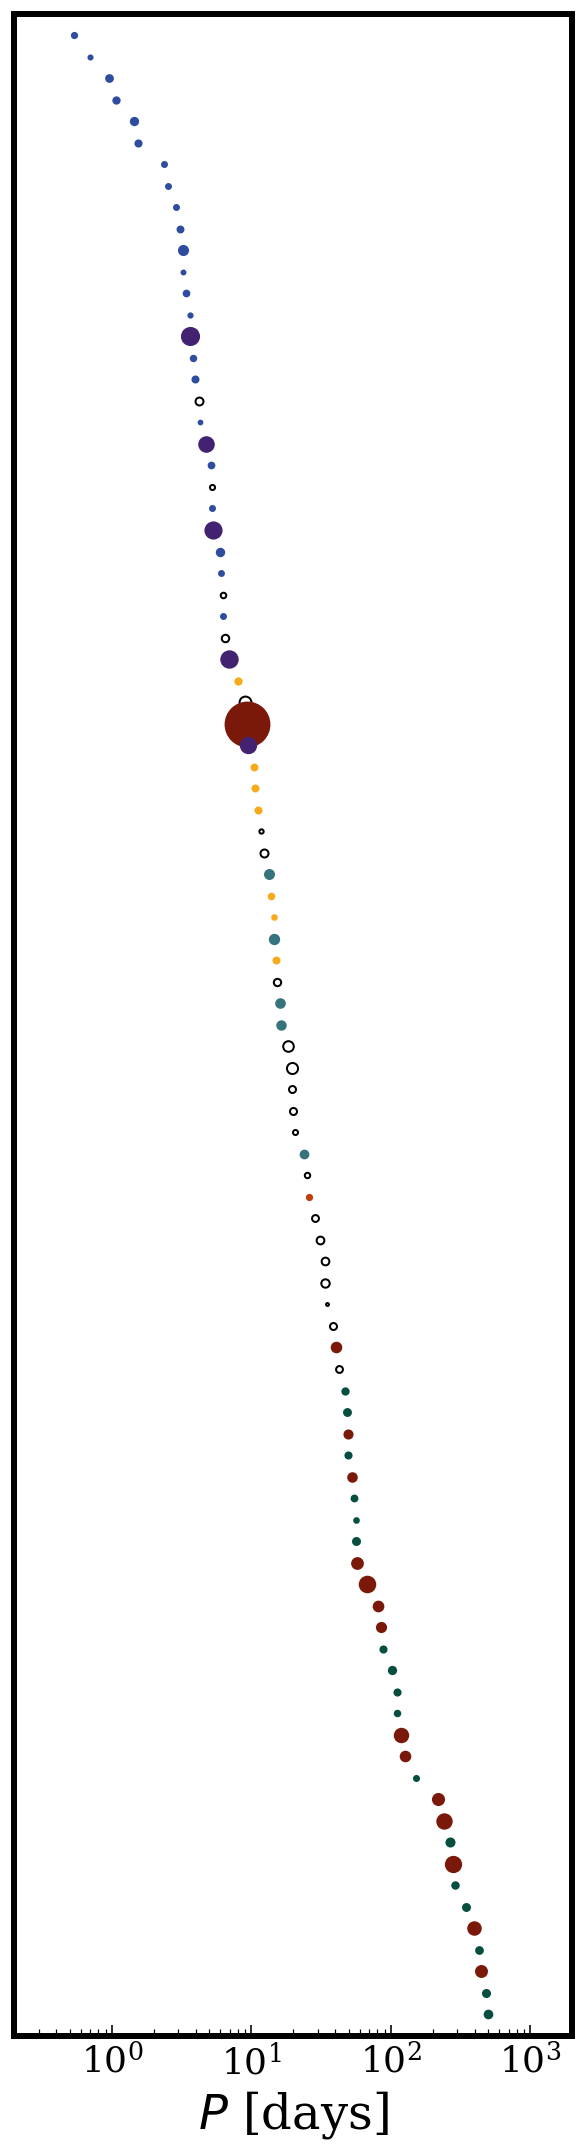

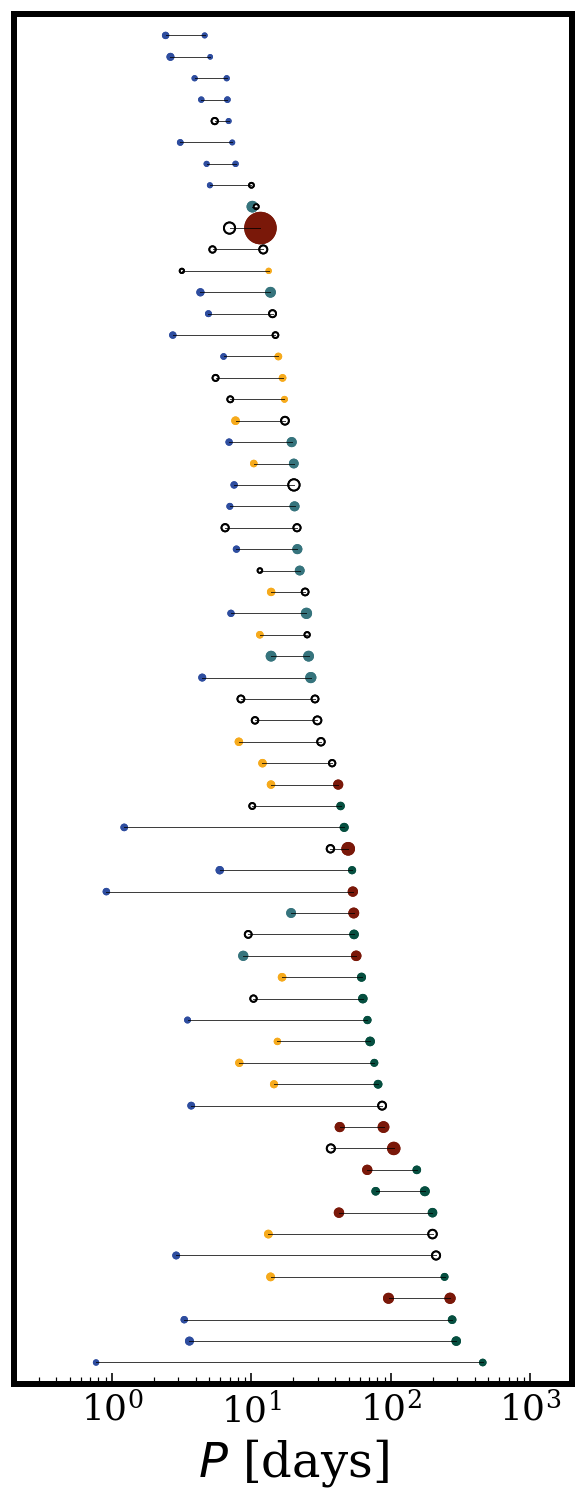

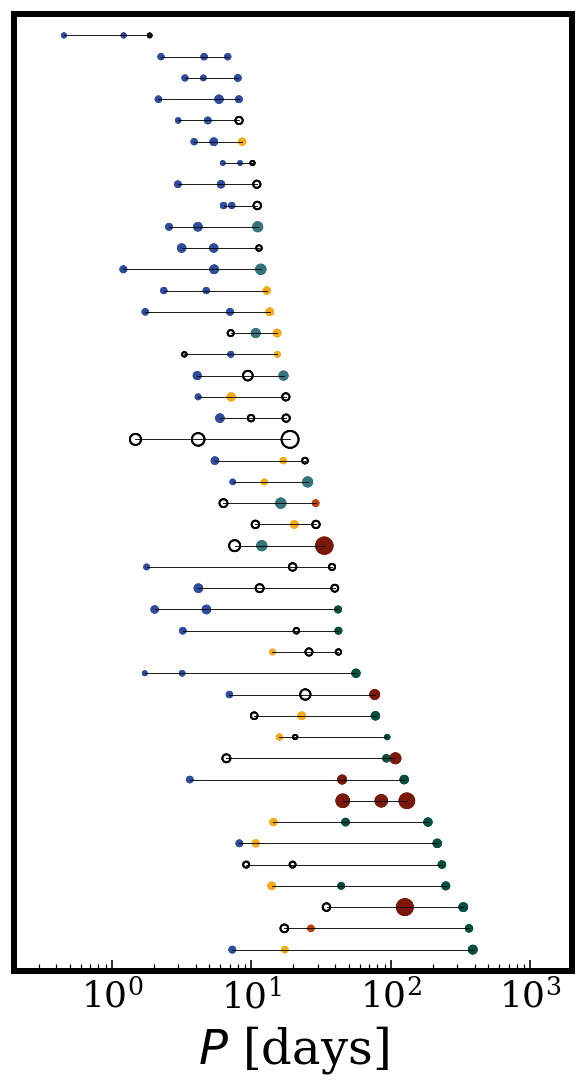

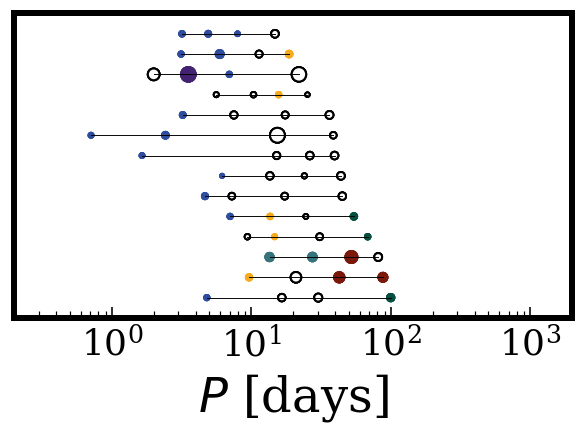

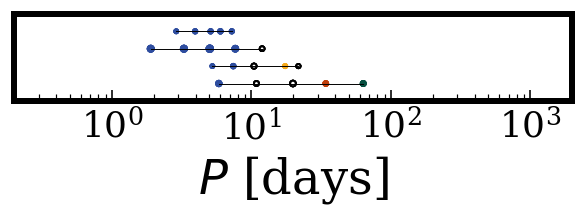

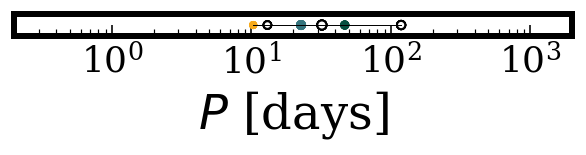

In [422]:
planetColours = ['#ffffff','#2e4d9f','#f6aa1c','#bf3e0b','#36747d','#064f40','#7a1809','#432371']

#the color planet i should be plotted is planetColours[planetType[i]]

print(np.shape(CVdata_toplot))

sysType = 'indeterminate'
sysTypeMask = iMask
sysIDs = iIDs_maj


for m in np.sort(np.unique(mults)):
    print("mult is {0}".format(m))
    mmask = (sysTypeMask) & (CVdata_toplot[:,-1] == m)
    
    CVdata_tp = CVdata_toplot[mmask]
    color_tp = planetType[mmask]
    
    print(np.shape(CVdata_tp))
    
    Pmaxs = np.zeros_like(CVdata_tp[:,4])
    #now sort by longest period in system
    for i, ID in enumerate(CVdata_tp[:,4]):
        thisSysMask = (CVdata_tp[:,4] == ID)
        Pmaxs[i] = np.max(CVdata_tp[:,0][thisSysMask])
        
    Pmaxsort = np.argsort(Pmaxs)
        
    CVdata_tp = CVdata_tp[Pmaxsort]
    color_tp = color_tp[Pmaxsort]
    
    #arrays_ = [array1[Pmaxsort], array2[Pmaxsort]]
    print(np.shape(CVdata_tp))
    print(np.shape(color_tp))
    
    if len(CVdata_tp) > 0:
        #class_colourMaps,class_colours,class_legendColours,class_legendEntries = makePlotColours(arrays_[h],classColoursList)

        fig, ax = plt.subplots(1,1,figsize=(5,len(np.unique(CVdata_tp[:,4]))/5.))
        #gs = gridspec.GridSpec((n_planet_features), (n_planet_features))

        current_ID = CVdata_toplot[0,4]
        current_i = len(np.unique(CVdata_tp[:,4]))

        for ID in (CVdata_tp[:,4]):
            if ID != current_ID:
                current_i = current_i - 1
            thisSysMask = (CVdata_tp[:,4] == ID)
            Ps = 10**((CVdata_tp[:,0][thisSysMask]*sigmas_swapped[0])+mus_swapped[0])
            Rs = 5*10**((CVdata_tp[:,1][thisSysMask]*sigmas_swapped[1])+mus_swapped[1])
            
            color_idxs = color_tp[thisSysMask]
            colors = [planetColours[int(cc)] for cc in color_idxs]

            ecs = []
            for c in range(len(colors)):
                if colors[c] == '#ffffff':
                    ecs.append('k')
                else:
                    ecs.append(colors[c])
            
            ax.scatter(Ps, np.ones_like(Ps)*current_i*2*m, s=Rs, c=colors,linewidths=1,edgecolors=ecs)
            if m > 1:
                ax.plot(Ps, np.ones_like(Ps)*current_i*2*m, marker='None',ls='-',color='k',lw=0.5,alpha=0.5)
            current_ID = ID
        ax.set_ylim(-2*m,len(np.unique(CVdata_tp[:,4]))*2*m)
        ax.set_yticks([])
        ax.set_xlim(0.2,2000)
        ax.set_xlabel(r'$P$ [days]',fontsize=24)
        ax.tick_params(labelsize=18)
        ax.set_xscale('log')
        #plt.show()


        plt.savefig("./realPlanets_incJ_final/persistentGroupings_upto10/realKOIs_finalFeatures_incJ_30percent_systemGrammar_{0}_mult={1}.pdf".format(sysType,m),fmt="pdf",bbox_inches="tight")
        #plt.close()


4286
76


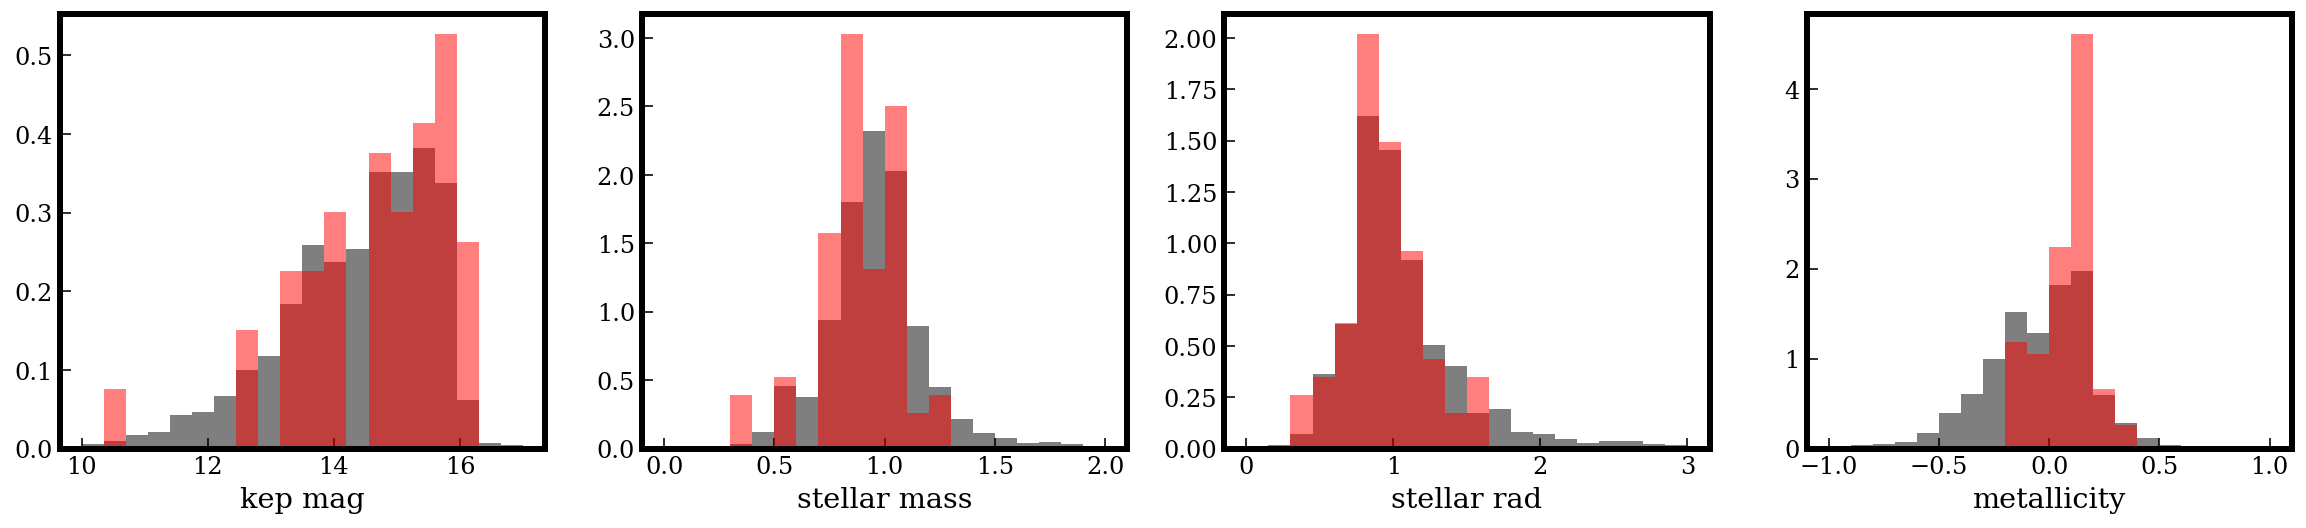

In [435]:
# just check: are the "who?" stars different?
kepid = np.array(KOIs['kepid'])

who_mask = []

for jj in range(len(kepid)):
    if kepid[jj] in whoIDs_maj:
        who_mask.append(True)
    else:
        who_mask.append(False)
who_mask = np.array(who_mask)

kepmag = np.array(KOIs['koi_kepmag'])
smass = np.array(KOIs['koi_smass'])
srad = np.array(KOIs['koi_srad'])
smet = np.array(KOIs['koi_smet'])

print(len(kepid))
print(len(kepid[who_mask]))

arrs = [kepmag,smass,srad,smet,sage]
arrnames=['kep mag','stellar mass','stellar rad','metallicity']
ranges=[(10,17),(0,2),(0,3),(-1,1)]

fig,axes=plt.subplots(1,4,figsize=(20,4))
for ii in range(4):
    axes[ii].hist(arrs[ii],color='k',range=ranges[ii],bins=20,alpha=0.5,density=True)
    axes[ii].hist(arrs[ii][who_mask],color='r',range=ranges[ii],bins=20,alpha=0.5,density=True)
    axes[ii].set_xlabel(arrnames[ii])
plt.show()